In [3]:
import argparse
import os
import numpy as np
import math

import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms

from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

torch.manual_seed(1337)

device = torch.device("cpu")
torch.set_default_device(device)

print(device)

os.makedirs("images", exist_ok=True)

# # parser = argparse.ArgumentParser()
# # parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
# # parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
# # parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
# # parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
# # parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
# # parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
# # parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
# # parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
# # parser.add_argument("--channels", type=int, default=1, help="number of image channels")
# # parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
# # opt = parser.parse_args()
# print(opt)



epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 100
img_size = 32
channels = 1
sample_interval = 50


mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
transform=transforms.Compose([
    transforms.Resize(img_size), 
])

# raw_data = mnist_trainset.data.float()
# labels = mnist_trainset.targets


# print(raw_data.shape)
# val_feat = raw_data[0:10000]
# train_feat = raw_data[10000:]
# print("raw std", torch.std(train_feat))
# aug_feat = train_feat.clone().detach()
# for i in range(3):
#     aug_feat = torch.cat((aug_feat, transforms.Compose([
#         transforms.RandomRotation([-15, 15], interpolation=transforms.InterpolationMode.BILINEAR, fill=0)
#     ])(train_feat)))

# aug_feat.detach()
# print("augmented shape", aug_feat.shape)
# print("augmented std", torch.std(aug_feat), torch.min(aug_feat), torch.max(aug_feat))


# features = ((aug_feat - 127.5) / 128.0).float().to(device)

features = mnist_trainset.data.float().to(device)
features = transform(features).detach() / 127.5 - 1.0
print(torch.max(features), torch.min(features))
print(torch.std(features), torch.mean(features), features.shape)
labels = mnist_trainset.targets.to(device)



cpu


/Users/jturunen/repos/mnist-vae/.conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(1.) tensor(-1.)
tensor(0.5785) tensor(-0.7383) torch.Size([60000, 32, 32])


In [4]:
def weights_init_normal(m: torch.nn.Module):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# torch.Size([8192, 100]) tensor(0.0004, device='mps:0') tensor(2.5486e-07, device='mps:0')
# torch.Size([8192]) tensor(0.0010, device='mps:0') tensor(-1.4779e-12, device='mps:0')
# torch.Size([128]) tensor(0.0019, device='mps:0') tensor(-1.7495e-05, device='mps:0')
# torch.Size([128]) tensor(0.0015, device='mps:0') tensor(0.0002, device='mps:0')
# torch.Size([128, 128, 3, 3]) tensor(0.0014, device='mps:0') tensor(-1.7944e-05, device='mps:0')
# torch.Size([128]) tensor(2.6233e-10, device='mps:0') tensor(-5.5138e-12, device='mps:0')
# torch.Size([128]) tensor(0.0011, device='mps:0') tensor(-8.1985e-06, device='mps:0')
# torch.Size([128]) tensor(0.0006, device='mps:0') tensor(5.5067e-05, device='mps:0')
# torch.Size([64, 128, 3, 3]) tensor(0.0008, device='mps:0') tensor(-0.0003, device='mps:0')
# torch.Size([64]) tensor(5.2482e-10, device='mps:0') tensor(-6.1220e-11, device='mps:0')
# torch.Size([64]) tensor(0.0017, device='mps:0') tensor(-0.0004, device='mps:0')
# torch.Size([64]) tensor(0.0046, device='mps:0') tensor(-0.0043, device='mps:0')
# torch.Size([1, 64, 3, 3]) tensor(0.0154, device='mps:0') tensor(0.0160, device='mps:0')
# torch.Size([1]) tensor(nan, device='mps:0') tensor(0.0846, device='mps:0')

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.01),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.01),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.01))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


In [5]:
def grad_stats(m: torch.nn.Module):
    for p in m.parameters():
        print(p.shape, torch.std(p.grad), torch.mean(p.grad))

[Epoch 0/200] [Batch 0/937/0] [D loss: 0.717941] [G loss: 0.749883]
std: tensor(0.3069) mean: tensor(-0.0638) min: tensor(-0.7739) max: tensor(0.8367)


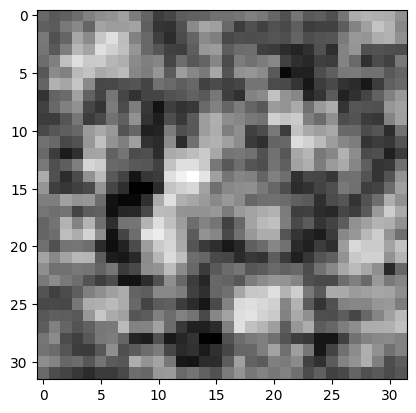

torch.Size([8192, 100]) tensor(8.9004e-05) tensor(4.8675e-08)
torch.Size([8192]) tensor(0.0002) tensor(-1.1369e-13)
torch.Size([128]) tensor(0.0004) tensor(1.3182e-06)
torch.Size([128]) tensor(0.0002) tensor(-1.4211e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0006) tensor(1.9109e-06)
torch.Size([128]) tensor(3.6799e-10) tensor(7.4465e-12)
torch.Size([128]) tensor(0.0004) tensor(1.0464e-06)
torch.Size([128]) tensor(0.0002) tensor(-9.7611e-06)
torch.Size([64, 128, 3, 3]) tensor(0.0008) tensor(3.1118e-06)
torch.Size([64]) tensor(1.3718e-09) tensor(-1.5052e-10)
torch.Size([64]) tensor(0.0005) tensor(6.0261e-05)
torch.Size([64]) tensor(0.0005) tensor(3.5600e-05)
torch.Size([1, 64, 3, 3]) tensor(0.0082) tensor(-0.0021)
torch.Size([1]) tensor(nan) tensor(-0.0084)
[Epoch 0/200] [Batch 1/937/1] [D loss: 0.708789] [G loss: 0.709007]
[Epoch 0/200] [Batch 2/937/2] [D loss: 0.697852] [G loss: 0.712720]
[Epoch 0/200] [Batch 3/937/3] [D loss: 0.687824] [G loss: 0.700832]
[Epoch 0/200] [Batch 4/937/4] 

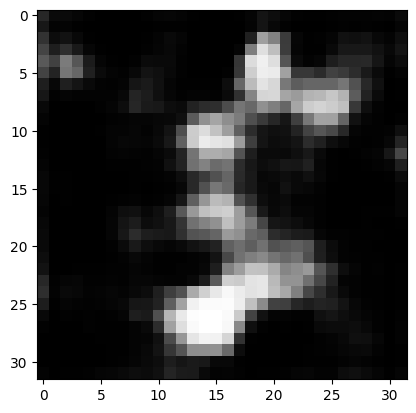

torch.Size([8192, 100]) tensor(0.0005) tensor(4.7590e-07)
torch.Size([8192]) tensor(0.0017) tensor(9.0949e-13)
torch.Size([128]) tensor(0.0023) tensor(1.0508e-06)
torch.Size([128]) tensor(0.0006) tensor(-8.7083e-06)
torch.Size([128, 128, 3, 3]) tensor(0.0022) tensor(-9.1341e-05)
torch.Size([128]) tensor(6.7581e-10) tensor(8.3460e-11)
torch.Size([128]) tensor(0.0018) tensor(-8.6513e-05)
torch.Size([128]) tensor(0.0012) tensor(0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0016) tensor(-0.0004)
torch.Size([64]) tensor(1.2076e-09) tensor(3.7325e-11)
torch.Size([64]) tensor(0.0046) tensor(-0.0040)
torch.Size([64]) tensor(0.0097) tensor(-0.0086)
torch.Size([1, 64, 3, 3]) tensor(0.0137) tensor(0.0556)
torch.Size([1]) tensor(nan) tensor(0.1953)
[Epoch 0/200] [Batch 51/937/51] [D loss: 0.643625] [G loss: 0.810631]
[Epoch 0/200] [Batch 52/937/52] [D loss: 0.651168] [G loss: 0.813723]
[Epoch 0/200] [Batch 53/937/53] [D loss: 0.703155] [G loss: 0.640835]
[Epoch 0/200] [Batch 54/937/54] [D loss: 0.6

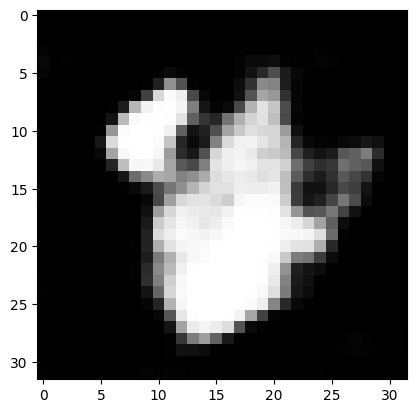

torch.Size([8192, 100]) tensor(0.0005) tensor(-2.1423e-06)
torch.Size([8192]) tensor(0.0019) tensor(-2.7285e-12)
torch.Size([128]) tensor(0.0026) tensor(-1.9582e-05)
torch.Size([128]) tensor(0.0017) tensor(-0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0020) tensor(-6.2961e-05)
torch.Size([128]) tensor(5.4752e-10) tensor(-8.5265e-14)
torch.Size([128]) tensor(0.0016) tensor(-2.6419e-05)
torch.Size([128]) tensor(0.0010) tensor(0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0011) tensor(-0.0004)
torch.Size([64]) tensor(6.5957e-10) tensor(-6.8880e-11)
torch.Size([64]) tensor(0.0027) tensor(-0.0015)
torch.Size([64]) tensor(0.0072) tensor(-0.0067)
torch.Size([1, 64, 3, 3]) tensor(0.0184) tensor(0.0283)
torch.Size([1]) tensor(nan) tensor(0.1296)
[Epoch 0/200] [Batch 101/937/101] [D loss: 0.638866] [G loss: 0.877410]
[Epoch 0/200] [Batch 102/937/102] [D loss: 0.673452] [G loss: 0.934001]
[Epoch 0/200] [Batch 103/937/103] [D loss: 0.662015] [G loss: 0.982869]
[Epoch 0/200] [Batch 104/937/104] [D 

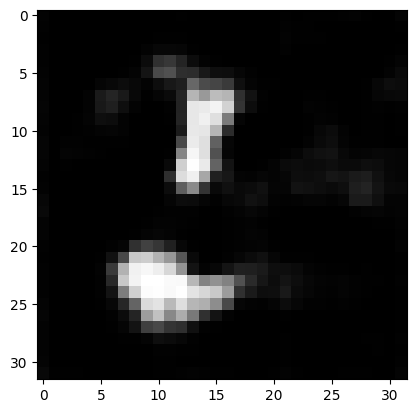

torch.Size([8192, 100]) tensor(0.0004) tensor(-3.9371e-07)
torch.Size([8192]) tensor(0.0014) tensor(-2.3874e-12)
torch.Size([128]) tensor(0.0017) tensor(5.9987e-06)
torch.Size([128]) tensor(0.0004) tensor(4.2328e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0016) tensor(1.0051e-05)
torch.Size([128]) tensor(3.1699e-10) tensor(2.3125e-11)
torch.Size([128]) tensor(0.0012) tensor(-1.4917e-05)
torch.Size([128]) tensor(0.0006) tensor(-5.2476e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0013) tensor(2.4681e-05)
torch.Size([64]) tensor(4.4158e-10) tensor(3.2969e-12)
torch.Size([64]) tensor(0.0009) tensor(-0.0009)
torch.Size([64]) tensor(0.0009) tensor(-0.0011)
torch.Size([1, 64, 3, 3]) tensor(0.0078) tensor(0.0048)
torch.Size([1]) tensor(nan) tensor(0.0138)
[Epoch 0/200] [Batch 151/937/151] [D loss: 0.647021] [G loss: 0.692014]
[Epoch 0/200] [Batch 152/937/152] [D loss: 0.642425] [G loss: 0.707675]
[Epoch 0/200] [Batch 153/937/153] [D loss: 0.673368] [G loss: 0.700106]
[Epoch 0/200] [Batch 154/937/1

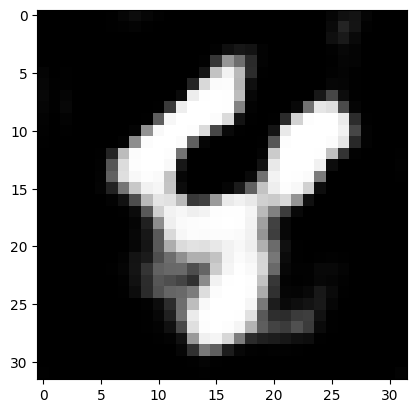

torch.Size([8192, 100]) tensor(0.0004) tensor(1.4571e-06)
torch.Size([8192]) tensor(0.0012) tensor(1.3642e-12)
torch.Size([128]) tensor(0.0017) tensor(9.8230e-06)
torch.Size([128]) tensor(0.0008) tensor(0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0013) tensor(8.5016e-05)
torch.Size([128]) tensor(3.6834e-10) tensor(-4.5000e-11)
torch.Size([128]) tensor(0.0010) tensor(-9.5767e-06)
torch.Size([128]) tensor(0.0005) tensor(-3.4338e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0009) tensor(0.0002)
torch.Size([64]) tensor(3.5093e-10) tensor(-3.6266e-11)
torch.Size([64]) tensor(0.0011) tensor(-0.0007)
torch.Size([64]) tensor(0.0013) tensor(0.0010)
torch.Size([1, 64, 3, 3]) tensor(0.0135) tensor(-0.0051)
torch.Size([1]) tensor(nan) tensor(-0.0234)
[Epoch 0/200] [Batch 201/937/201] [D loss: 0.707732] [G loss: 0.767317]
[Epoch 0/200] [Batch 202/937/202] [D loss: 0.704733] [G loss: 0.791082]
[Epoch 0/200] [Batch 203/937/203] [D loss: 0.679401] [G loss: 0.740396]
[Epoch 0/200] [Batch 204/937/204] [D 

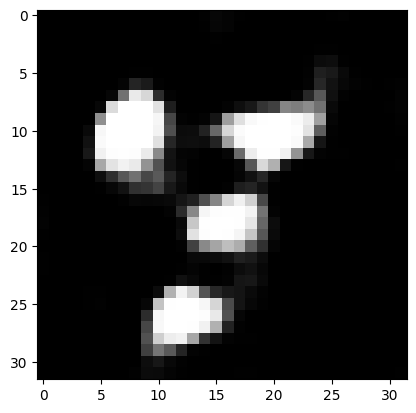

torch.Size([8192, 100]) tensor(0.0003) tensor(1.1944e-06)
torch.Size([8192]) tensor(0.0011) tensor(3.4106e-13)
torch.Size([128]) tensor(0.0018) tensor(2.4309e-06)
torch.Size([128]) tensor(0.0002) tensor(-1.0988e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0013) tensor(1.2227e-05)
torch.Size([128]) tensor(3.2373e-10) tensor(1.3965e-11)
torch.Size([128]) tensor(0.0009) tensor(-5.4754e-06)
torch.Size([128]) tensor(0.0004) tensor(1.9463e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0008) tensor(-0.0001)
torch.Size([64]) tensor(2.8358e-10) tensor(6.6095e-11)
torch.Size([64]) tensor(0.0006) tensor(-0.0003)
torch.Size([64]) tensor(0.0011) tensor(-0.0012)
torch.Size([1, 64, 3, 3]) tensor(0.0056) tensor(0.0052)
torch.Size([1]) tensor(nan) tensor(0.0178)
[Epoch 0/200] [Batch 251/937/251] [D loss: 0.678410] [G loss: 0.700013]
[Epoch 0/200] [Batch 252/937/252] [D loss: 0.697135] [G loss: 0.715963]
[Epoch 0/200] [Batch 253/937/253] [D loss: 0.694402] [G loss: 0.692680]
[Epoch 0/200] [Batch 254/937/254] [

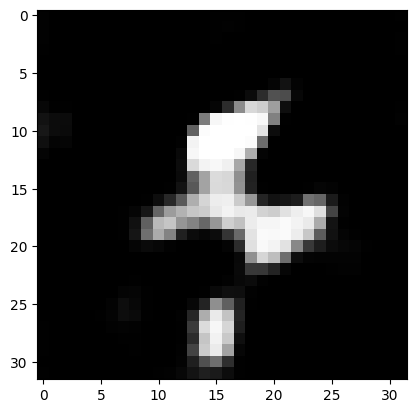

torch.Size([8192, 100]) tensor(0.0002) tensor(1.3620e-06)
torch.Size([8192]) tensor(0.0006) tensor(3.6380e-12)
torch.Size([128]) tensor(0.0011) tensor(3.1892e-06)
torch.Size([128]) tensor(0.0003) tensor(4.7822e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0009) tensor(-3.5018e-06)
torch.Size([128]) tensor(2.1159e-10) tensor(1.3273e-11)
torch.Size([128]) tensor(0.0005) tensor(-4.6383e-06)
torch.Size([128]) tensor(0.0003) tensor(-4.1836e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0006) tensor(7.4773e-05)
torch.Size([64]) tensor(2.5284e-10) tensor(1.1404e-11)
torch.Size([64]) tensor(0.0005) tensor(-0.0002)
torch.Size([64]) tensor(0.0004) tensor(0.0002)
torch.Size([1, 64, 3, 3]) tensor(0.0046) tensor(-0.0011)
torch.Size([1]) tensor(nan) tensor(-0.0040)
[Epoch 0/200] [Batch 301/937/301] [D loss: 0.692766] [G loss: 0.667656]
[Epoch 0/200] [Batch 302/937/302] [D loss: 0.698457] [G loss: 0.678982]
[Epoch 0/200] [Batch 303/937/303] [D loss: 0.677500] [G loss: 0.682496]
[Epoch 0/200] [Batch 304/937/3

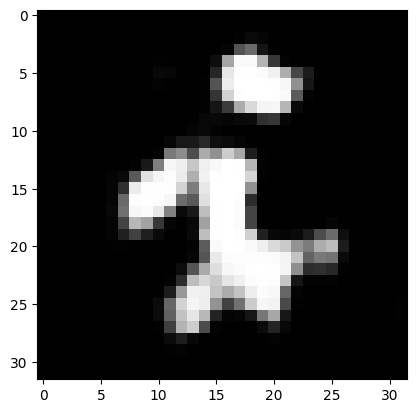

torch.Size([8192, 100]) tensor(0.0004) tensor(-4.7149e-07)
torch.Size([8192]) tensor(0.0016) tensor(7.7307e-12)
torch.Size([128]) tensor(0.0018) tensor(1.1796e-05)
torch.Size([128]) tensor(0.0006) tensor(0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0015) tensor(-1.4092e-05)
torch.Size([128]) tensor(3.3765e-10) tensor(-1.2763e-11)
torch.Size([128]) tensor(0.0011) tensor(-2.3011e-06)
torch.Size([128]) tensor(0.0005) tensor(-7.1861e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0008) tensor(8.3080e-05)
torch.Size([64]) tensor(2.8507e-10) tensor(-1.9241e-11)
torch.Size([64]) tensor(0.0008) tensor(-0.0002)
torch.Size([64]) tensor(0.0012) tensor(0.0011)
torch.Size([1, 64, 3, 3]) tensor(0.0083) tensor(-0.0036)
torch.Size([1]) tensor(nan) tensor(-0.0198)
[Epoch 0/200] [Batch 351/937/351] [D loss: 0.718066] [G loss: 0.720626]
[Epoch 0/200] [Batch 352/937/352] [D loss: 0.695549] [G loss: 0.736393]
[Epoch 0/200] [Batch 353/937/353] [D loss: 0.724974] [G loss: 0.702438]
[Epoch 0/200] [Batch 354/937/35

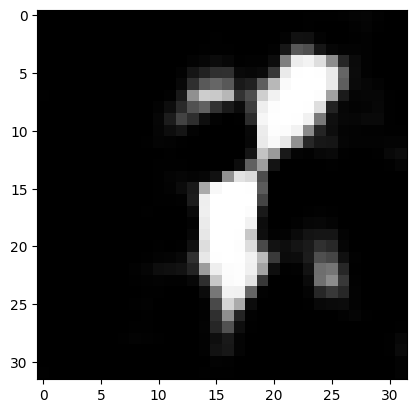

torch.Size([8192, 100]) tensor(0.0003) tensor(2.3774e-07)
torch.Size([8192]) tensor(0.0011) tensor(5.0022e-12)
torch.Size([128]) tensor(0.0016) tensor(2.2291e-06)
torch.Size([128]) tensor(0.0002) tensor(4.8135e-06)
torch.Size([128, 128, 3, 3]) tensor(0.0012) tensor(7.3176e-05)
torch.Size([128]) tensor(3.0782e-10) tensor(3.9215e-11)
torch.Size([128]) tensor(0.0008) tensor(9.4370e-07)
torch.Size([128]) tensor(0.0005) tensor(-5.5955e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0008) tensor(-6.2174e-06)
torch.Size([64]) tensor(3.0985e-10) tensor(-6.5725e-12)
torch.Size([64]) tensor(0.0006) tensor(3.6385e-05)
torch.Size([64]) tensor(0.0005) tensor(-0.0001)
torch.Size([1, 64, 3, 3]) tensor(0.0054) tensor(0.0006)
torch.Size([1]) tensor(nan) tensor(0.0028)
[Epoch 0/200] [Batch 401/937/401] [D loss: 0.686088] [G loss: 0.774243]
[Epoch 0/200] [Batch 402/937/402] [D loss: 0.707837] [G loss: 0.739740]
[Epoch 0/200] [Batch 403/937/403] [D loss: 0.697991] [G loss: 0.721196]
[Epoch 0/200] [Batch 404/937

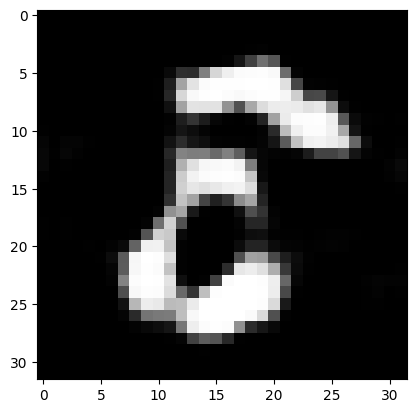

torch.Size([8192, 100]) tensor(0.0003) tensor(-3.8847e-07)
torch.Size([8192]) tensor(0.0008) tensor(2.3590e-12)
torch.Size([128]) tensor(0.0013) tensor(2.5377e-06)
torch.Size([128]) tensor(0.0001) tensor(8.1174e-06)
torch.Size([128, 128, 3, 3]) tensor(0.0010) tensor(-6.4263e-06)
torch.Size([128]) tensor(2.2695e-10) tensor(2.3032e-11)
torch.Size([128]) tensor(0.0006) tensor(8.1127e-07)
torch.Size([128]) tensor(0.0003) tensor(4.8113e-06)
torch.Size([64, 128, 3, 3]) tensor(0.0007) tensor(-4.8485e-05)
torch.Size([64]) tensor(2.7972e-10) tensor(-6.3807e-12)
torch.Size([64]) tensor(0.0006) tensor(3.0129e-05)
torch.Size([64]) tensor(0.0006) tensor(-0.0005)
torch.Size([1, 64, 3, 3]) tensor(0.0052) tensor(0.0015)
torch.Size([1]) tensor(nan) tensor(0.0082)
[Epoch 0/200] [Batch 451/937/451] [D loss: 0.692735] [G loss: 0.722397]
[Epoch 0/200] [Batch 452/937/452] [D loss: 0.675554] [G loss: 0.714419]
[Epoch 0/200] [Batch 453/937/453] [D loss: 0.702885] [G loss: 0.720843]
[Epoch 0/200] [Batch 454/93

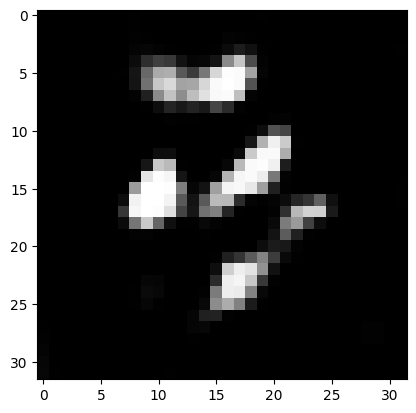

torch.Size([8192, 100]) tensor(0.0003) tensor(-1.4368e-06)
torch.Size([8192]) tensor(0.0007) tensor(-1.4495e-12)
torch.Size([128]) tensor(0.0013) tensor(-5.7013e-06)
torch.Size([128]) tensor(9.0683e-05) tensor(-8.3980e-06)
torch.Size([128, 128, 3, 3]) tensor(0.0011) tensor(-3.4457e-06)
torch.Size([128]) tensor(3.1919e-10) tensor(-1.7074e-11)
torch.Size([128]) tensor(0.0006) tensor(8.2931e-07)
torch.Size([128]) tensor(0.0004) tensor(4.3466e-06)
torch.Size([64, 128, 3, 3]) tensor(0.0008) tensor(-0.0001)
torch.Size([64]) tensor(3.0596e-10) tensor(-4.9113e-11)
torch.Size([64]) tensor(0.0008) tensor(-3.1996e-05)
torch.Size([64]) tensor(0.0010) tensor(-0.0011)
torch.Size([1, 64, 3, 3]) tensor(0.0071) tensor(0.0036)
torch.Size([1]) tensor(nan) tensor(0.0175)
[Epoch 0/200] [Batch 501/937/501] [D loss: 0.687737] [G loss: 0.706090]
[Epoch 0/200] [Batch 502/937/502] [D loss: 0.660025] [G loss: 0.703187]
[Epoch 0/200] [Batch 503/937/503] [D loss: 0.676780] [G loss: 0.676928]
[Epoch 0/200] [Batch 5

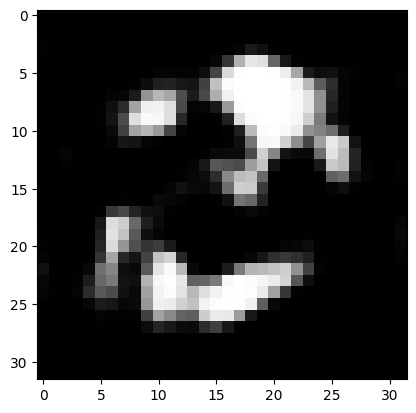

torch.Size([8192, 100]) tensor(0.0004) tensor(2.1331e-07)
torch.Size([8192]) tensor(0.0016) tensor(6.8212e-13)
torch.Size([128]) tensor(0.0021) tensor(-5.4662e-06)
torch.Size([128]) tensor(0.0003) tensor(-3.0046e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0015) tensor(4.7750e-06)
torch.Size([128]) tensor(3.5827e-10) tensor(-6.7304e-11)
torch.Size([128]) tensor(0.0009) tensor(-2.3752e-07)
torch.Size([128]) tensor(0.0005) tensor(6.6799e-06)
torch.Size([64, 128, 3, 3]) tensor(0.0010) tensor(-3.7064e-05)
torch.Size([64]) tensor(4.0478e-10) tensor(4.9226e-11)
torch.Size([64]) tensor(0.0009) tensor(9.9078e-05)
torch.Size([64]) tensor(0.0012) tensor(-0.0012)
torch.Size([1, 64, 3, 3]) tensor(0.0081) tensor(0.0036)
torch.Size([1]) tensor(nan) tensor(0.0204)
[Epoch 0/200] [Batch 551/937/551] [D loss: 0.667497] [G loss: 0.764019]
[Epoch 0/200] [Batch 552/937/552] [D loss: 0.672915] [G loss: 0.794846]
[Epoch 0/200] [Batch 553/937/553] [D loss: 0.670112] [G loss: 0.741204]
[Epoch 0/200] [Batch 554/9

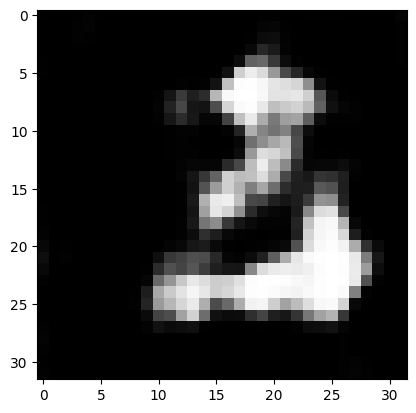

torch.Size([8192, 100]) tensor(0.0003) tensor(5.7651e-07)
torch.Size([8192]) tensor(0.0006) tensor(-2.2737e-13)
torch.Size([128]) tensor(0.0011) tensor(6.1980e-06)
torch.Size([128]) tensor(0.0004) tensor(4.5711e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0009) tensor(2.2251e-05)
torch.Size([128]) tensor(1.9138e-10) tensor(-3.0969e-11)
torch.Size([128]) tensor(0.0007) tensor(-5.6638e-07)
torch.Size([128]) tensor(0.0004) tensor(-4.9257e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0007) tensor(0.0002)
torch.Size([64]) tensor(2.5448e-10) tensor(-1.6644e-11)
torch.Size([64]) tensor(0.0007) tensor(-7.2193e-05)
torch.Size([64]) tensor(0.0009) tensor(0.0010)
torch.Size([1, 64, 3, 3]) tensor(0.0096) tensor(-0.0047)
torch.Size([1]) tensor(nan) tensor(-0.0157)
[Epoch 0/200] [Batch 601/937/601] [D loss: 0.698318] [G loss: 0.669870]
[Epoch 0/200] [Batch 602/937/602] [D loss: 0.695092] [G loss: 0.718509]
[Epoch 0/200] [Batch 603/937/603] [D loss: 0.681986] [G loss: 0.726323]
[Epoch 0/200] [Batch 604/937

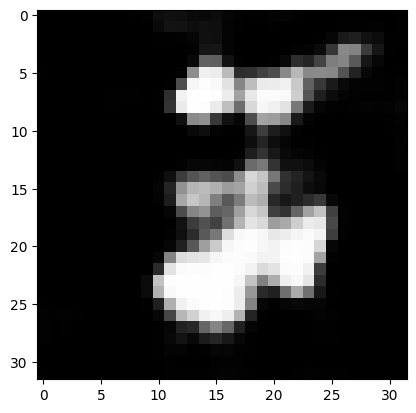

torch.Size([8192, 100]) tensor(0.0004) tensor(5.4647e-07)
torch.Size([8192]) tensor(0.0017) tensor(5.2296e-12)
torch.Size([128]) tensor(0.0020) tensor(-2.6902e-06)
torch.Size([128]) tensor(0.0002) tensor(-4.7253e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0014) tensor(-3.4989e-06)
torch.Size([128]) tensor(3.2393e-10) tensor(4.1524e-11)
torch.Size([128]) tensor(0.0010) tensor(3.3067e-06)
torch.Size([128]) tensor(0.0006) tensor(1.4675e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0010) tensor(-9.4926e-05)
torch.Size([64]) tensor(3.2450e-10) tensor(2.0783e-11)
torch.Size([64]) tensor(0.0013) tensor(0.0003)
torch.Size([64]) tensor(0.0015) tensor(-0.0016)
torch.Size([1, 64, 3, 3]) tensor(0.0155) tensor(0.0054)
torch.Size([1]) tensor(nan) tensor(0.0286)
[Epoch 0/200] [Batch 651/937/651] [D loss: 0.675748] [G loss: 0.803669]
[Epoch 0/200] [Batch 652/937/652] [D loss: 0.678243] [G loss: 0.803273]
[Epoch 0/200] [Batch 653/937/653] [D loss: 0.672086] [G loss: 0.887165]
[Epoch 0/200] [Batch 654/937/65

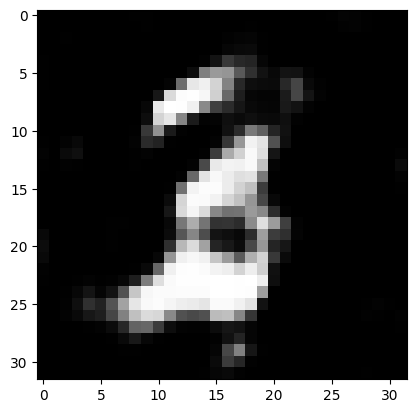

torch.Size([8192, 100]) tensor(0.0004) tensor(2.1582e-06)
torch.Size([8192]) tensor(0.0015) tensor(-1.1369e-12)
torch.Size([128]) tensor(0.0019) tensor(-5.8102e-06)
torch.Size([128]) tensor(7.8536e-05) tensor(-7.5075e-07)
torch.Size([128, 128, 3, 3]) tensor(0.0014) tensor(7.5731e-06)
torch.Size([128]) tensor(3.1563e-10) tensor(-2.9344e-11)
torch.Size([128]) tensor(0.0008) tensor(-1.3447e-06)
torch.Size([128]) tensor(0.0004) tensor(-2.3751e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0010) tensor(-1.2188e-05)
torch.Size([64]) tensor(3.9726e-10) tensor(-6.1668e-11)
torch.Size([64]) tensor(0.0008) tensor(-1.2029e-05)
torch.Size([64]) tensor(0.0007) tensor(-0.0008)
torch.Size([1, 64, 3, 3]) tensor(0.0100) tensor(0.0034)
torch.Size([1]) tensor(nan) tensor(0.0123)
[Epoch 0/200] [Batch 701/937/701] [D loss: 0.661927] [G loss: 0.786204]
[Epoch 0/200] [Batch 702/937/702] [D loss: 0.675817] [G loss: 0.723921]
[Epoch 0/200] [Batch 703/937/703] [D loss: 0.687601] [G loss: 0.738687]
[Epoch 0/200] [Bat

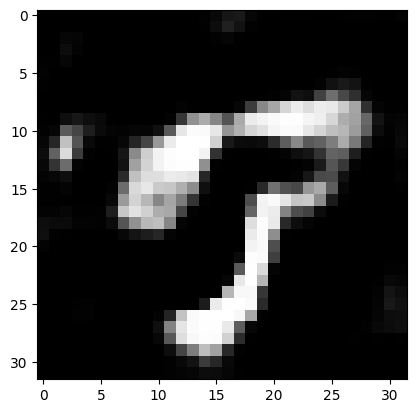

torch.Size([8192, 100]) tensor(0.0004) tensor(8.4319e-07)
torch.Size([8192]) tensor(0.0011) tensor(-1.3642e-12)
torch.Size([128]) tensor(0.0022) tensor(9.0170e-06)
torch.Size([128]) tensor(0.0009) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0013) tensor(-4.4057e-06)
torch.Size([128]) tensor(3.8519e-10) tensor(3.3673e-11)
torch.Size([128]) tensor(0.0016) tensor(-3.9641e-06)
torch.Size([128]) tensor(0.0007) tensor(-6.2115e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0013) tensor(0.0004)
torch.Size([64]) tensor(4.1797e-10) tensor(6.4496e-11)
torch.Size([64]) tensor(0.0032) tensor(-0.0004)
torch.Size([64]) tensor(0.0029) tensor(0.0039)
torch.Size([1, 64, 3, 3]) tensor(0.0322) tensor(-0.0161)
torch.Size([1]) tensor(nan) tensor(-0.0610)
[Epoch 0/200] [Batch 751/937/751] [D loss: 0.659150] [G loss: 0.698902]
[Epoch 0/200] [Batch 752/937/752] [D loss: 0.669845] [G loss: 0.712853]
[Epoch 0/200] [Batch 753/937/753] [D loss: 0.667694] [G loss: 0.761099]
[Epoch 0/200] [Batch 754/937/754] [D 

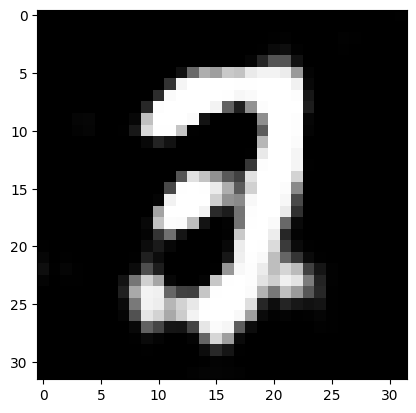

torch.Size([8192, 100]) tensor(0.0006) tensor(-1.4466e-06)
torch.Size([8192]) tensor(0.0023) tensor(-2.2737e-12)
torch.Size([128]) tensor(0.0029) tensor(1.2133e-05)
torch.Size([128]) tensor(0.0011) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0018) tensor(-8.2155e-05)
torch.Size([128]) tensor(3.6273e-10) tensor(2.9225e-11)
torch.Size([128]) tensor(0.0015) tensor(3.7323e-07)
torch.Size([128]) tensor(0.0007) tensor(-7.4533e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0011) tensor(0.0002)
torch.Size([64]) tensor(3.5569e-10) tensor(-5.2914e-11)
torch.Size([64]) tensor(0.0015) tensor(-0.0004)
torch.Size([64]) tensor(0.0019) tensor(0.0023)
torch.Size([1, 64, 3, 3]) tensor(0.0152) tensor(-0.0066)
torch.Size([1]) tensor(nan) tensor(-0.0366)
[Epoch 0/200] [Batch 801/937/801] [D loss: 0.716448] [G loss: 0.781513]
[Epoch 0/200] [Batch 802/937/802] [D loss: 0.711670] [G loss: 0.758654]
[Epoch 0/200] [Batch 803/937/803] [D loss: 0.680076] [G loss: 0.802998]
[Epoch 0/200] [Batch 804/937/804] [D

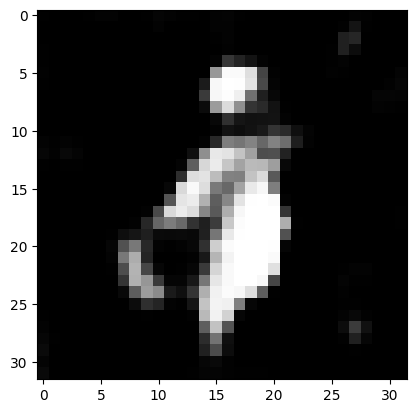

torch.Size([8192, 100]) tensor(0.0007) tensor(6.2361e-07)
torch.Size([8192]) tensor(0.0018) tensor(-4.5475e-13)
torch.Size([128]) tensor(0.0032) tensor(8.1324e-06)
torch.Size([128]) tensor(0.0008) tensor(0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0020) tensor(3.2679e-06)
torch.Size([128]) tensor(5.0457e-10) tensor(-4.9702e-12)
torch.Size([128]) tensor(0.0014) tensor(-6.8465e-07)
torch.Size([128]) tensor(0.0007) tensor(-7.0361e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0012) tensor(5.4728e-05)
torch.Size([64]) tensor(4.7810e-10) tensor(-7.2866e-11)
torch.Size([64]) tensor(0.0016) tensor(-0.0001)
torch.Size([64]) tensor(0.0013) tensor(0.0013)
torch.Size([1, 64, 3, 3]) tensor(0.0153) tensor(-0.0011)
torch.Size([1]) tensor(nan) tensor(-0.0161)
[Epoch 0/200] [Batch 851/937/851] [D loss: 0.631793] [G loss: 0.766032]
[Epoch 0/200] [Batch 852/937/852] [D loss: 0.653539] [G loss: 0.827802]
[Epoch 0/200] [Batch 853/937/853] [D loss: 0.662681] [G loss: 0.793073]
[Epoch 0/200] [Batch 854/937/854

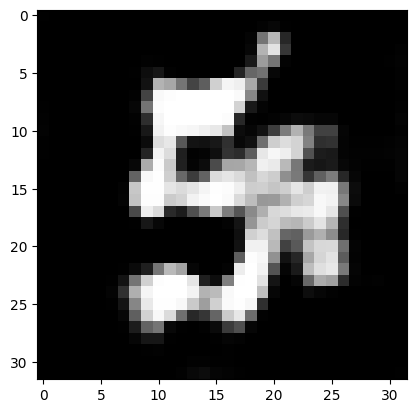

torch.Size([8192, 100]) tensor(0.0008) tensor(-6.3044e-06)
torch.Size([8192]) tensor(0.0029) tensor(-1.8190e-12)
torch.Size([128]) tensor(0.0038) tensor(-2.1399e-05)
torch.Size([128]) tensor(0.0019) tensor(-0.0004)
torch.Size([128, 128, 3, 3]) tensor(0.0023) tensor(3.1555e-06)
torch.Size([128]) tensor(5.8465e-10) tensor(-1.0770e-10)
torch.Size([128]) tensor(0.0029) tensor(8.0195e-07)
torch.Size([128]) tensor(0.0014) tensor(4.9521e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0020) tensor(-0.0007)
torch.Size([64]) tensor(7.4006e-10) tensor(-1.7316e-11)
torch.Size([64]) tensor(0.0077) tensor(0.0008)
torch.Size([64]) tensor(0.0066) tensor(-0.0103)
torch.Size([1, 64, 3, 3]) tensor(0.0656) tensor(0.0289)
torch.Size([1]) tensor(nan) tensor(0.1564)
[Epoch 0/200] [Batch 901/937/901] [D loss: 0.644843] [G loss: 0.890228]
[Epoch 0/200] [Batch 902/937/902] [D loss: 0.671401] [G loss: 0.839421]
[Epoch 0/200] [Batch 903/937/903] [D loss: 0.716865] [G loss: 0.738451]
[Epoch 0/200] [Batch 904/937/904] [D

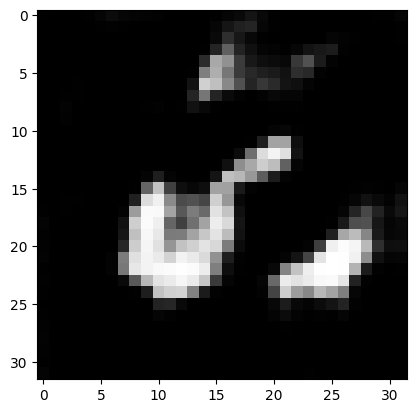

torch.Size([8192, 100]) tensor(0.0006) tensor(-2.0743e-06)
torch.Size([8192]) tensor(0.0020) tensor(4.0927e-12)
torch.Size([128]) tensor(0.0032) tensor(1.1389e-05)
torch.Size([128]) tensor(0.0010) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0021) tensor(-1.9082e-06)
torch.Size([128]) tensor(5.4039e-10) tensor(3.3225e-11)
torch.Size([128]) tensor(0.0020) tensor(-6.3218e-06)
torch.Size([128]) tensor(0.0010) tensor(1.7150e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0018) tensor(0.0004)
torch.Size([64]) tensor(5.7865e-10) tensor(2.0123e-11)
torch.Size([64]) tensor(0.0080) tensor(-0.0005)
torch.Size([64]) tensor(0.0053) tensor(0.0075)
torch.Size([1, 64, 3, 3]) tensor(0.0610) tensor(-0.0245)
torch.Size([1]) tensor(nan) tensor(-0.1166)
[Epoch 1/200] [Batch 14/937/951] [D loss: 0.637828] [G loss: 0.780743]
[Epoch 1/200] [Batch 15/937/952] [D loss: 0.601512] [G loss: 0.911728]
[Epoch 1/200] [Batch 16/937/953] [D loss: 0.673609] [G loss: 0.798155]
[Epoch 1/200] [Batch 17/937/954] [D loss:

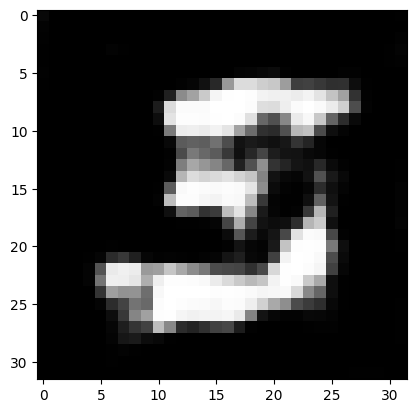

torch.Size([8192, 100]) tensor(0.0009) tensor(2.2786e-06)
torch.Size([8192]) tensor(0.0018) tensor(-2.0464e-12)
torch.Size([128]) tensor(0.0040) tensor(3.1520e-06)
torch.Size([128]) tensor(0.0003) tensor(4.1903e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0023) tensor(1.6235e-05)
torch.Size([128]) tensor(6.4143e-10) tensor(1.3273e-11)
torch.Size([128]) tensor(0.0020) tensor(-3.6990e-06)
torch.Size([128]) tensor(0.0010) tensor(0.0001)
torch.Size([64, 128, 3, 3]) tensor(0.0017) tensor(-0.0001)
torch.Size([64]) tensor(5.3802e-10) tensor(-1.1610e-10)
torch.Size([64]) tensor(0.0064) tensor(5.2652e-05)
torch.Size([64]) tensor(0.0030) tensor(-0.0037)
torch.Size([1, 64, 3, 3]) tensor(0.0458) tensor(0.0152)
torch.Size([1]) tensor(nan) tensor(0.0559)
[Epoch 1/200] [Batch 64/937/1001] [D loss: 0.634428] [G loss: 0.742267]
[Epoch 1/200] [Batch 65/937/1002] [D loss: 0.652733] [G loss: 0.722165]
[Epoch 1/200] [Batch 66/937/1003] [D loss: 0.627260] [G loss: 0.855596]
[Epoch 1/200] [Batch 67/937/1004] [

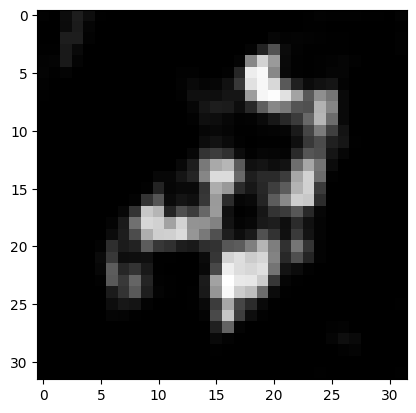

torch.Size([8192, 100]) tensor(0.0009) tensor(-7.6912e-07)
torch.Size([8192]) tensor(0.0023) tensor(-2.9559e-12)
torch.Size([128]) tensor(0.0049) tensor(2.6025e-05)
torch.Size([128]) tensor(0.0013) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0030) tensor(3.0112e-05)
torch.Size([128]) tensor(6.6220e-10) tensor(7.4174e-11)
torch.Size([128]) tensor(0.0038) tensor(-1.2867e-05)
torch.Size([128]) tensor(0.0018) tensor(7.3649e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0041) tensor(0.0014)
torch.Size([64]) tensor(1.1531e-09) tensor(3.9421e-11)
torch.Size([64]) tensor(0.0214) tensor(-0.0006)
torch.Size([64]) tensor(0.0122) tensor(0.0179)
torch.Size([1, 64, 3, 3]) tensor(0.1692) tensor(-0.0702)
torch.Size([1]) tensor(nan) tensor(-0.2558)
[Epoch 1/200] [Batch 114/937/1051] [D loss: 0.685567] [G loss: 0.617039]
[Epoch 1/200] [Batch 115/937/1052] [D loss: 0.669946] [G loss: 0.815268]
[Epoch 1/200] [Batch 116/937/1053] [D loss: 0.580437] [G loss: 0.897149]
[Epoch 1/200] [Batch 117/937/1054] 

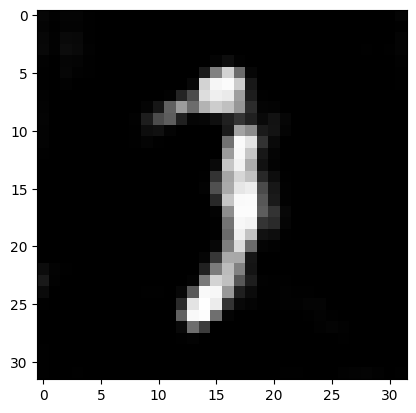

torch.Size([8192, 100]) tensor(0.0011) tensor(2.0129e-06)
torch.Size([8192]) tensor(0.0024) tensor(6.3665e-12)
torch.Size([128]) tensor(0.0051) tensor(3.7476e-05)
torch.Size([128]) tensor(0.0014) tensor(0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0032) tensor(3.2889e-05)
torch.Size([128]) tensor(8.4188e-10) tensor(-1.6762e-10)
torch.Size([128]) tensor(0.0024) tensor(-5.5212e-06)
torch.Size([128]) tensor(0.0012) tensor(-9.0055e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0021) tensor(0.0001)
torch.Size([64]) tensor(6.8748e-10) tensor(-2.3624e-10)
torch.Size([64]) tensor(0.0029) tensor(-0.0007)
torch.Size([64]) tensor(0.0023) tensor(0.0025)
torch.Size([1, 64, 3, 3]) tensor(0.0256) tensor(-0.0011)
torch.Size([1]) tensor(nan) tensor(-0.0365)
[Epoch 1/200] [Batch 164/937/1101] [D loss: 0.632466] [G loss: 0.985973]
[Epoch 1/200] [Batch 165/937/1102] [D loss: 0.591623] [G loss: 0.793936]
[Epoch 1/200] [Batch 166/937/1103] [D loss: 0.623796] [G loss: 0.742246]
[Epoch 1/200] [Batch 167/937/1104]

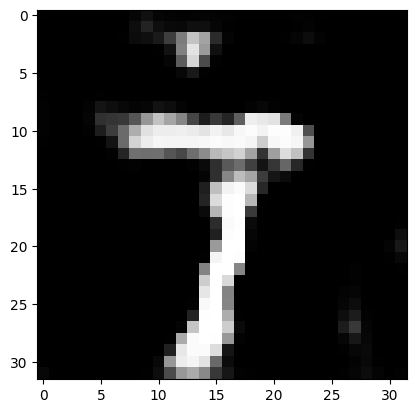

torch.Size([8192, 100]) tensor(0.0013) tensor(6.1878e-06)
torch.Size([8192]) tensor(0.0031) tensor(7.2760e-12)
torch.Size([128]) tensor(0.0061) tensor(2.4311e-05)
torch.Size([128]) tensor(0.0005) tensor(6.9142e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0033) tensor(3.0189e-05)
torch.Size([128]) tensor(8.1600e-10) tensor(-1.3639e-10)
torch.Size([128]) tensor(0.0025) tensor(5.1377e-06)
torch.Size([128]) tensor(0.0015) tensor(-0.0001)
torch.Size([64, 128, 3, 3]) tensor(0.0021) tensor(-0.0004)
torch.Size([64]) tensor(7.1003e-10) tensor(-7.8387e-11)
torch.Size([64]) tensor(0.0074) tensor(-0.0007)
torch.Size([64]) tensor(0.0031) tensor(-0.0045)
torch.Size([1, 64, 3, 3]) tensor(0.0479) tensor(0.0135)
torch.Size([1]) tensor(nan) tensor(0.0550)
[Epoch 1/200] [Batch 214/937/1151] [D loss: 0.625419] [G loss: 1.091803]
[Epoch 1/200] [Batch 215/937/1152] [D loss: 0.593983] [G loss: 0.836204]
[Epoch 1/200] [Batch 216/937/1153] [D loss: 0.560330] [G loss: 0.684918]
[Epoch 1/200] [Batch 217/937/1154] 

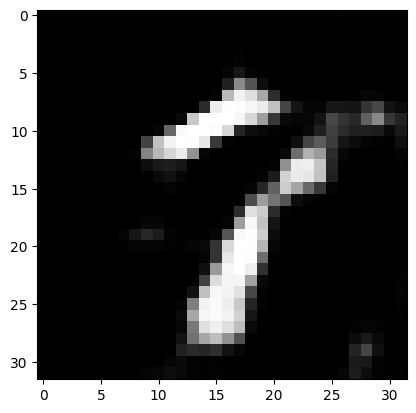

torch.Size([8192, 100]) tensor(0.0012) tensor(-7.9539e-06)
torch.Size([8192]) tensor(0.0022) tensor(-6.3949e-14)
torch.Size([128]) tensor(0.0058) tensor(1.4852e-06)
torch.Size([128]) tensor(0.0006) tensor(-4.0005e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0030) tensor(-6.7017e-06)
torch.Size([128]) tensor(6.8052e-10) tensor(2.2709e-11)
torch.Size([128]) tensor(0.0025) tensor(6.8978e-06)
torch.Size([128]) tensor(0.0013) tensor(0.0001)
torch.Size([64, 128, 3, 3]) tensor(0.0020) tensor(-0.0002)
torch.Size([64]) tensor(6.8199e-10) tensor(-8.4242e-11)
torch.Size([64]) tensor(0.0059) tensor(-0.0004)
torch.Size([64]) tensor(0.0035) tensor(-0.0031)
torch.Size([1, 64, 3, 3]) tensor(0.0358) tensor(0.0077)
torch.Size([1]) tensor(nan) tensor(0.0386)
[Epoch 1/200] [Batch 264/937/1201] [D loss: 0.633339] [G loss: 0.854145]
[Epoch 1/200] [Batch 265/937/1202] [D loss: 0.608998] [G loss: 0.893300]
[Epoch 1/200] [Batch 266/937/1203] [D loss: 0.645871] [G loss: 0.903152]
[Epoch 1/200] [Batch 267/937/1204

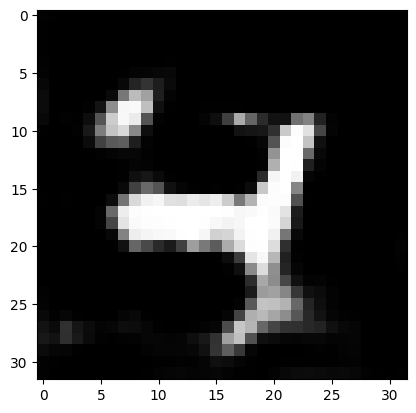

torch.Size([8192, 100]) tensor(0.0014) tensor(-2.8388e-06)
torch.Size([8192]) tensor(0.0030) tensor(-2.7285e-12)
torch.Size([128]) tensor(0.0069) tensor(-5.6856e-06)
torch.Size([128]) tensor(0.0004) tensor(-3.5557e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0036) tensor(1.6207e-05)
torch.Size([128]) tensor(9.5279e-10) tensor(-1.0242e-10)
torch.Size([128]) tensor(0.0033) tensor(6.2804e-06)
torch.Size([128]) tensor(0.0016) tensor(-0.0001)
torch.Size([64, 128, 3, 3]) tensor(0.0025) tensor(-0.0006)
torch.Size([64]) tensor(8.4407e-10) tensor(-8.0348e-11)
torch.Size([64]) tensor(0.0047) tensor(-0.0006)
torch.Size([64]) tensor(0.0039) tensor(0.0001)
torch.Size([1, 64, 3, 3]) tensor(0.0338) tensor(0.0041)
torch.Size([1]) tensor(nan) tensor(-0.0079)
[Epoch 1/200] [Batch 314/937/1251] [D loss: 0.545418] [G loss: 1.043444]
[Epoch 1/200] [Batch 315/937/1252] [D loss: 0.692182] [G loss: 1.083921]
[Epoch 1/200] [Batch 316/937/1253] [D loss: 0.661479] [G loss: 0.675414]
[Epoch 1/200] [Batch 317/937/12

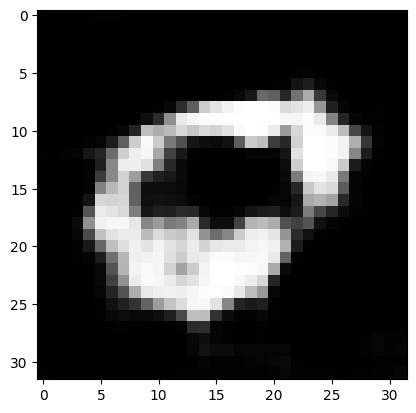

torch.Size([8192, 100]) tensor(0.0014) tensor(1.4928e-06)
torch.Size([8192]) tensor(0.0021) tensor(4.5475e-12)
torch.Size([128]) tensor(0.0061) tensor(5.0411e-06)
torch.Size([128]) tensor(0.0007) tensor(-8.4132e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0035) tensor(9.3721e-06)
torch.Size([128]) tensor(8.7297e-10) tensor(1.2417e-10)
torch.Size([128]) tensor(0.0038) tensor(1.4322e-05)
torch.Size([128]) tensor(0.0019) tensor(0.0005)
torch.Size([64, 128, 3, 3]) tensor(0.0031) tensor(-0.0004)
torch.Size([64]) tensor(8.5419e-10) tensor(-2.9576e-10)
torch.Size([64]) tensor(0.0112) tensor(-0.0005)
torch.Size([64]) tensor(0.0060) tensor(-0.0062)
torch.Size([1, 64, 3, 3]) tensor(0.0697) tensor(0.0132)
torch.Size([1]) tensor(nan) tensor(0.0780)
[Epoch 1/200] [Batch 364/937/1301] [D loss: 0.671234] [G loss: 0.857078]
[Epoch 1/200] [Batch 365/937/1302] [D loss: 0.639270] [G loss: 0.864922]
[Epoch 1/200] [Batch 366/937/1303] [D loss: 0.634796] [G loss: 0.913423]
[Epoch 1/200] [Batch 367/937/1304] [

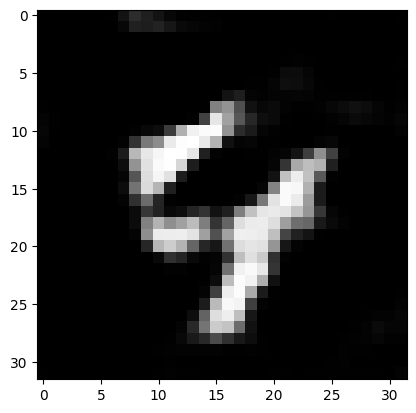

torch.Size([8192, 100]) tensor(0.0012) tensor(-5.0394e-06)
torch.Size([8192]) tensor(0.0018) tensor(-2.7285e-12)
torch.Size([128]) tensor(0.0060) tensor(1.9021e-05)
torch.Size([128]) tensor(0.0011) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0029) tensor(-3.6112e-05)
torch.Size([128]) tensor(7.9833e-10) tensor(-4.4366e-11)
torch.Size([128]) tensor(0.0024) tensor(-4.3890e-06)
torch.Size([128]) tensor(0.0012) tensor(0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0021) tensor(0.0003)
torch.Size([64]) tensor(6.5076e-10) tensor(-2.0103e-10)
torch.Size([64]) tensor(0.0048) tensor(-0.0005)
torch.Size([64]) tensor(0.0044) tensor(0.0029)
torch.Size([1, 64, 3, 3]) tensor(0.0251) tensor(-0.0071)
torch.Size([1]) tensor(nan) tensor(-0.0401)
[Epoch 1/200] [Batch 414/937/1351] [D loss: 0.616004] [G loss: 0.912210]
[Epoch 1/200] [Batch 415/937/1352] [D loss: 0.629720] [G loss: 0.955453]
[Epoch 1/200] [Batch 416/937/1353] [D loss: 0.669904] [G loss: 0.836785]
[Epoch 1/200] [Batch 417/937/1354] [

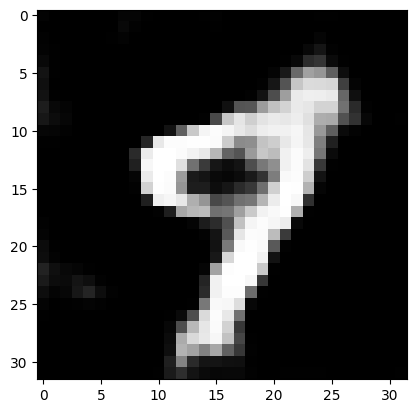

torch.Size([8192, 100]) tensor(0.0015) tensor(-5.2820e-06)
torch.Size([8192]) tensor(0.0026) tensor(5.4570e-12)
torch.Size([128]) tensor(0.0070) tensor(1.6084e-05)
torch.Size([128]) tensor(0.0009) tensor(-2.1854e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0035) tensor(-5.8807e-06)
torch.Size([128]) tensor(8.8089e-10) tensor(-1.0316e-10)
torch.Size([128]) tensor(0.0035) tensor(-4.9531e-06)
torch.Size([128]) tensor(0.0021) tensor(7.4518e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0026) tensor(3.9378e-05)
torch.Size([64]) tensor(8.0044e-10) tensor(-1.1323e-10)
torch.Size([64]) tensor(0.0067) tensor(-0.0005)
torch.Size([64]) tensor(0.0038) tensor(0.0004)
torch.Size([1, 64, 3, 3]) tensor(0.0376) tensor(-0.0021)
torch.Size([1]) tensor(nan) tensor(-0.0036)
[Epoch 1/200] [Batch 464/937/1401] [D loss: 0.624948] [G loss: 1.205790]
[Epoch 1/200] [Batch 465/937/1402] [D loss: 0.654416] [G loss: 0.837750]
[Epoch 1/200] [Batch 466/937/1403] [D loss: 0.592200] [G loss: 0.805394]
[Epoch 1/200] [Batch 467

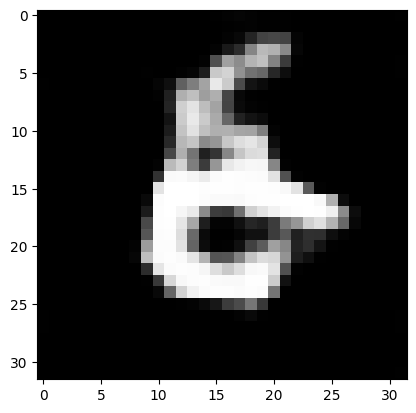

torch.Size([8192, 100]) tensor(0.0014) tensor(6.1830e-06)
torch.Size([8192]) tensor(0.0018) tensor(-2.6148e-12)
torch.Size([128]) tensor(0.0068) tensor(-5.8855e-05)
torch.Size([128]) tensor(0.0016) tensor(-0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0034) tensor(3.3077e-05)
torch.Size([128]) tensor(8.2128e-10) tensor(-5.3149e-12)
torch.Size([128]) tensor(0.0033) tensor(1.4111e-05)
torch.Size([128]) tensor(0.0019) tensor(0.0001)
torch.Size([64, 128, 3, 3]) tensor(0.0024) tensor(-0.0002)
torch.Size([64]) tensor(9.2750e-10) tensor(-6.5356e-11)
torch.Size([64]) tensor(0.0084) tensor(-0.0004)
torch.Size([64]) tensor(0.0109) tensor(-0.0129)
torch.Size([1, 64, 3, 3]) tensor(0.0485) tensor(0.0252)
torch.Size([1]) tensor(nan) tensor(0.1437)
[Epoch 1/200] [Batch 514/937/1451] [D loss: 0.589308] [G loss: 0.912900]
[Epoch 1/200] [Batch 515/937/1452] [D loss: 0.566261] [G loss: 0.807010]
[Epoch 1/200] [Batch 516/937/1453] [D loss: 0.666043] [G loss: 0.877143]
[Epoch 1/200] [Batch 517/937/1454] [D

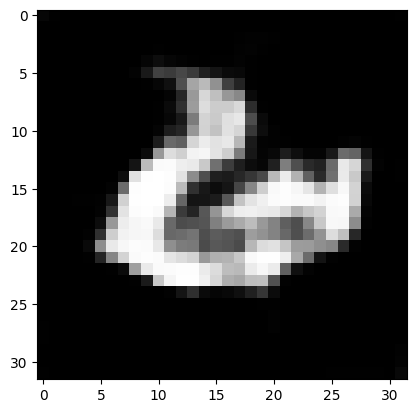

torch.Size([8192, 100]) tensor(0.0014) tensor(-2.9527e-06)
torch.Size([8192]) tensor(0.0021) tensor(-5.4570e-12)
torch.Size([128]) tensor(0.0060) tensor(1.0850e-05)
torch.Size([128]) tensor(0.0004) tensor(6.2773e-06)
torch.Size([128, 128, 3, 3]) tensor(0.0034) tensor(-6.9053e-05)
torch.Size([128]) tensor(8.7289e-10) tensor(-7.1310e-11)
torch.Size([128]) tensor(0.0033) tensor(-8.5153e-06)
torch.Size([128]) tensor(0.0016) tensor(0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0029) tensor(6.0935e-05)
torch.Size([64]) tensor(1.0965e-09) tensor(-3.5379e-10)
torch.Size([64]) tensor(0.0119) tensor(-2.4778e-05)
torch.Size([64]) tensor(0.0043) tensor(-0.0023)
torch.Size([1, 64, 3, 3]) tensor(0.0660) tensor(0.0142)
torch.Size([1]) tensor(nan) tensor(0.0365)
[Epoch 1/200] [Batch 564/937/1501] [D loss: 0.660026] [G loss: 0.943636]
[Epoch 1/200] [Batch 565/937/1502] [D loss: 0.617330] [G loss: 0.853101]
[Epoch 1/200] [Batch 566/937/1503] [D loss: 0.602737] [G loss: 0.825024]
[Epoch 1/200] [Batch 567/

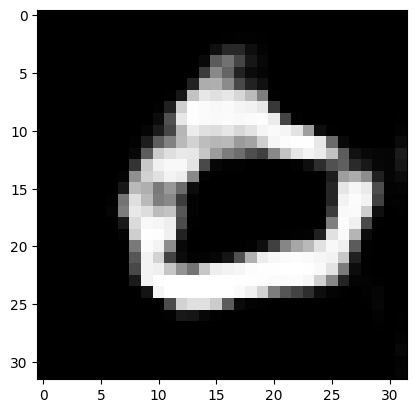

torch.Size([8192, 100]) tensor(0.0013) tensor(-5.8046e-06)
torch.Size([8192]) tensor(0.0015) tensor(5.4570e-12)
torch.Size([128]) tensor(0.0066) tensor(3.0890e-05)
torch.Size([128]) tensor(0.0005) tensor(-2.0924e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0031) tensor(-6.0609e-05)
torch.Size([128]) tensor(7.7561e-10) tensor(2.1089e-11)
torch.Size([128]) tensor(0.0024) tensor(8.3844e-06)
torch.Size([128]) tensor(0.0011) tensor(-8.4744e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0020) tensor(-9.6730e-05)
torch.Size([64]) tensor(8.6179e-10) tensor(-2.9240e-10)
torch.Size([64]) tensor(0.0038) tensor(-4.2245e-05)
torch.Size([64]) tensor(0.0018) tensor(0.0003)
torch.Size([1, 64, 3, 3]) tensor(0.0232) tensor(-0.0045)
torch.Size([1]) tensor(nan) tensor(-0.0031)
[Epoch 1/200] [Batch 614/937/1551] [D loss: 0.622617] [G loss: 0.842847]
[Epoch 1/200] [Batch 615/937/1552] [D loss: 0.546609] [G loss: 0.744394]
[Epoch 1/200] [Batch 616/937/1553] [D loss: 0.701338] [G loss: 0.725253]
[Epoch 1/200] [Batch

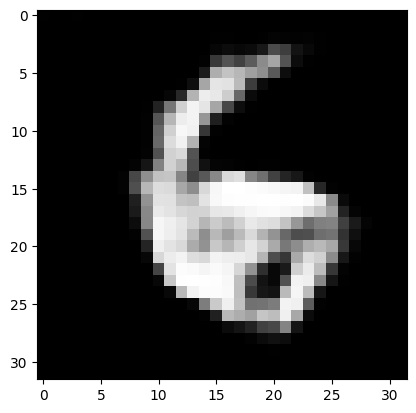

torch.Size([8192, 100]) tensor(0.0014) tensor(4.4454e-06)
torch.Size([8192]) tensor(0.0022) tensor(-2.5011e-12)
torch.Size([128]) tensor(0.0069) tensor(-8.3886e-06)
torch.Size([128]) tensor(0.0006) tensor(-7.9965e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0033) tensor(2.3371e-06)
torch.Size([128]) tensor(8.6090e-10) tensor(7.5502e-11)
torch.Size([128]) tensor(0.0029) tensor(1.5686e-05)
torch.Size([128]) tensor(0.0016) tensor(0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0025) tensor(-0.0002)
torch.Size([64]) tensor(8.0277e-10) tensor(-1.6981e-10)
torch.Size([64]) tensor(0.0055) tensor(-0.0009)
torch.Size([64]) tensor(0.0040) tensor(0.0005)
torch.Size([1, 64, 3, 3]) tensor(0.0304) tensor(-0.0054)
torch.Size([1]) tensor(nan) tensor(-0.0180)
[Epoch 1/200] [Batch 664/937/1601] [D loss: 0.637571] [G loss: 0.803578]
[Epoch 1/200] [Batch 665/937/1602] [D loss: 0.577982] [G loss: 0.919994]
[Epoch 1/200] [Batch 666/937/1603] [D loss: 0.553988] [G loss: 1.114529]
[Epoch 1/200] [Batch 667/937/1604

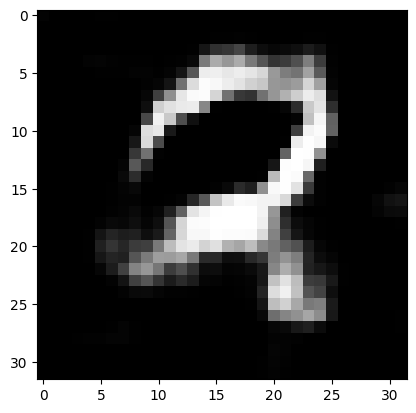

torch.Size([8192, 100]) tensor(0.0020) tensor(2.8304e-06)
torch.Size([8192]) tensor(0.0024) tensor(-2.2737e-13)
torch.Size([128]) tensor(0.0083) tensor(5.9410e-05)
torch.Size([128]) tensor(0.0017) tensor(0.0003)
torch.Size([128, 128, 3, 3]) tensor(0.0047) tensor(6.7010e-05)
torch.Size([128]) tensor(1.3180e-09) tensor(4.2021e-11)
torch.Size([128]) tensor(0.0048) tensor(2.2390e-05)
torch.Size([128]) tensor(0.0027) tensor(7.1919e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0037) tensor(0.0001)
torch.Size([64]) tensor(1.2265e-09) tensor(1.1613e-10)
torch.Size([64]) tensor(0.0074) tensor(-0.0013)
torch.Size([64]) tensor(0.0096) tensor(0.0099)
torch.Size([1, 64, 3, 3]) tensor(0.0428) tensor(-0.0064)
torch.Size([1]) tensor(nan) tensor(-0.1017)
[Epoch 1/200] [Batch 714/937/1651] [D loss: 0.570918] [G loss: 1.201302]
[Epoch 1/200] [Batch 715/937/1652] [D loss: 0.656507] [G loss: 0.994889]
[Epoch 1/200] [Batch 716/937/1653] [D loss: 0.574592] [G loss: 0.773456]
[Epoch 1/200] [Batch 717/937/1654] [D

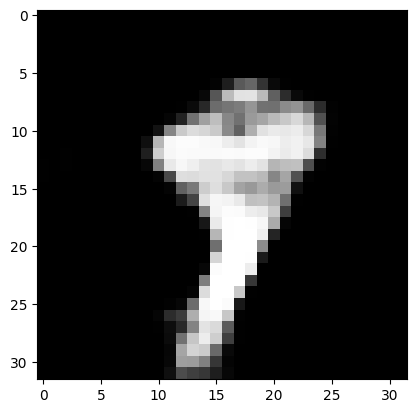

torch.Size([8192, 100]) tensor(0.0020) tensor(2.7454e-06)
torch.Size([8192]) tensor(0.0035) tensor(-1.2506e-12)
torch.Size([128]) tensor(0.0096) tensor(-7.0420e-05)
torch.Size([128]) tensor(0.0007) tensor(-0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0046) tensor(-2.3274e-06)
torch.Size([128]) tensor(1.0653e-09) tensor(-4.2519e-11)
torch.Size([128]) tensor(0.0045) tensor(9.9106e-06)
torch.Size([128]) tensor(0.0021) tensor(0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0035) tensor(-0.0005)
torch.Size([64]) tensor(1.2334e-09) tensor(-3.1940e-10)
torch.Size([64]) tensor(0.0143) tensor(-0.0007)
torch.Size([64]) tensor(0.0063) tensor(-0.0055)
torch.Size([1, 64, 3, 3]) tensor(0.0657) tensor(0.0132)
torch.Size([1]) tensor(nan) tensor(0.0624)
[Epoch 1/200] [Batch 764/937/1701] [D loss: 0.553352] [G loss: 1.123475]
[Epoch 1/200] [Batch 765/937/1702] [D loss: 0.623390] [G loss: 0.811734]
[Epoch 1/200] [Batch 766/937/1703] [D loss: 0.616377] [G loss: 0.870781]
[Epoch 1/200] [Batch 767/937/1704] [

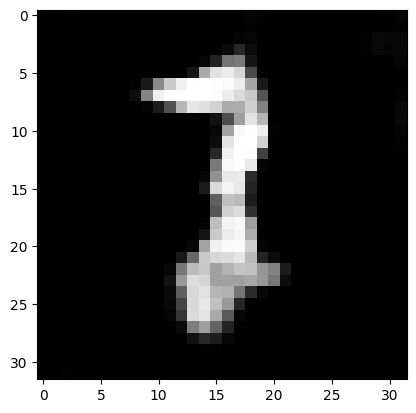

torch.Size([8192, 100]) tensor(0.0019) tensor(2.9828e-06)
torch.Size([8192]) tensor(0.0023) tensor(-9.3792e-12)
torch.Size([128]) tensor(0.0098) tensor(-4.5774e-05)
torch.Size([128]) tensor(0.0012) tensor(-0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0042) tensor(-7.0233e-05)
torch.Size([128]) tensor(1.1994e-09) tensor(1.0814e-11)
torch.Size([128]) tensor(0.0053) tensor(-2.0711e-05)
torch.Size([128]) tensor(0.0033) tensor(0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0038) tensor(-0.0003)
torch.Size([64]) tensor(1.1275e-09) tensor(-2.7342e-10)
torch.Size([64]) tensor(0.0117) tensor(4.3845e-05)
torch.Size([64]) tensor(0.0117) tensor(-0.0139)
torch.Size([1, 64, 3, 3]) tensor(0.0641) tensor(0.0267)
torch.Size([1]) tensor(nan) tensor(0.1505)
[Epoch 1/200] [Batch 814/937/1751] [D loss: 0.541162] [G loss: 1.003402]
[Epoch 1/200] [Batch 815/937/1752] [D loss: 0.659307] [G loss: 0.853730]
[Epoch 1/200] [Batch 816/937/1753] [D loss: 0.631322] [G loss: 1.243273]
[Epoch 1/200] [Batch 817/937/1754

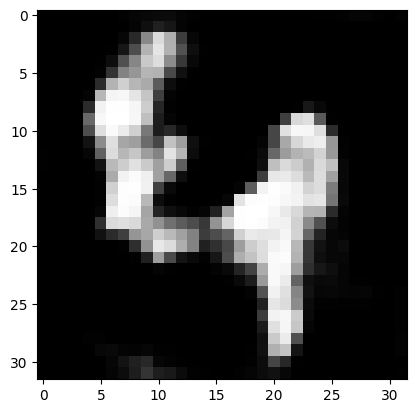

torch.Size([8192, 100]) tensor(0.0020) tensor(-5.9042e-06)
torch.Size([8192]) tensor(0.0023) tensor(-9.0949e-13)
torch.Size([128]) tensor(0.0087) tensor(1.0431e-05)
torch.Size([128]) tensor(0.0008) tensor(-5.7868e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0042) tensor(5.3734e-05)
torch.Size([128]) tensor(9.5424e-10) tensor(1.0166e-10)
torch.Size([128]) tensor(0.0043) tensor(2.5603e-05)
torch.Size([128]) tensor(0.0024) tensor(1.8593e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0031) tensor(-0.0003)
torch.Size([64]) tensor(1.3335e-09) tensor(-4.5077e-11)
torch.Size([64]) tensor(0.0082) tensor(-0.0009)
torch.Size([64]) tensor(0.0044) tensor(-0.0025)
torch.Size([1, 64, 3, 3]) tensor(0.0476) tensor(0.0135)
torch.Size([1]) tensor(nan) tensor(0.0125)
[Epoch 1/200] [Batch 864/937/1801] [D loss: 0.543129] [G loss: 1.154412]
[Epoch 1/200] [Batch 865/937/1802] [D loss: 0.532254] [G loss: 1.042982]
[Epoch 1/200] [Batch 866/937/1803] [D loss: 0.635355] [G loss: 0.777262]
[Epoch 1/200] [Batch 867/937/1

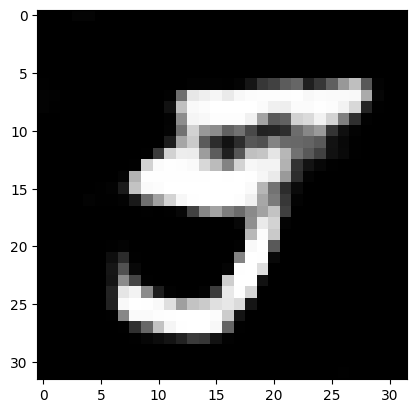

torch.Size([8192, 100]) tensor(0.0017) tensor(8.6865e-06)
torch.Size([8192]) tensor(0.0023) tensor(-3.1832e-12)
torch.Size([128]) tensor(0.0078) tensor(3.0989e-05)
torch.Size([128]) tensor(0.0005) tensor(9.3518e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0038) tensor(1.9849e-05)
torch.Size([128]) tensor(9.4561e-10) tensor(-3.8504e-11)
torch.Size([128]) tensor(0.0040) tensor(4.2276e-06)
torch.Size([128]) tensor(0.0023) tensor(0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0035) tensor(6.3423e-05)
torch.Size([64]) tensor(1.0428e-09) tensor(-1.3931e-10)
torch.Size([64]) tensor(0.0109) tensor(-0.0008)
torch.Size([64]) tensor(0.0050) tensor(-0.0012)
torch.Size([1, 64, 3, 3]) tensor(0.0632) tensor(-0.0008)
torch.Size([1]) tensor(nan) tensor(0.0196)
[Epoch 1/200] [Batch 914/937/1851] [D loss: 0.635572] [G loss: 1.376301]
[Epoch 1/200] [Batch 915/937/1852] [D loss: 0.647437] [G loss: 0.976705]
[Epoch 1/200] [Batch 916/937/1853] [D loss: 0.588532] [G loss: 0.865009]
[Epoch 1/200] [Batch 917/937/18

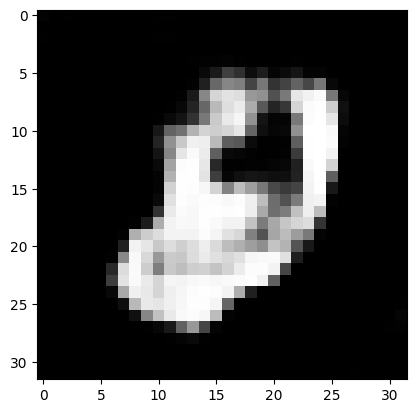

torch.Size([8192, 100]) tensor(0.0022) tensor(3.4143e-06)
torch.Size([8192]) tensor(0.0035) tensor(-1.0914e-11)
torch.Size([128]) tensor(0.0093) tensor(6.6680e-05)
torch.Size([128]) tensor(0.0018) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0052) tensor(0.0001)
torch.Size([128]) tensor(1.3571e-09) tensor(8.9528e-12)
torch.Size([128]) tensor(0.0083) tensor(-1.4721e-05)
torch.Size([128]) tensor(0.0043) tensor(0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0058) tensor(0.0008)
torch.Size([64]) tensor(1.5061e-09) tensor(-4.0586e-10)
torch.Size([64]) tensor(0.0197) tensor(-0.0002)
torch.Size([64]) tensor(0.0127) tensor(0.0123)
torch.Size([1, 64, 3, 3]) tensor(0.1065) tensor(-0.0245)
torch.Size([1]) tensor(nan) tensor(-0.1406)
[Epoch 2/200] [Batch 26/937/1901] [D loss: 0.613953] [G loss: 0.798880]
[Epoch 2/200] [Batch 27/937/1902] [D loss: 0.560645] [G loss: 0.991234]
[Epoch 2/200] [Batch 28/937/1903] [D loss: 0.669067] [G loss: 0.898274]
[Epoch 2/200] [Batch 29/937/1904] [D loss: 0.6

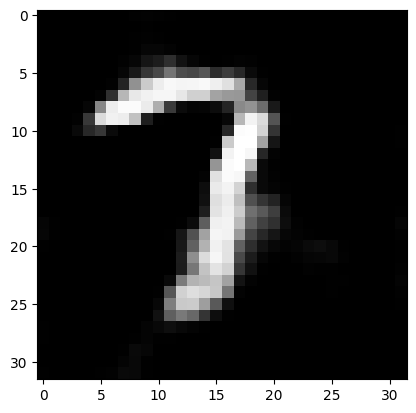

torch.Size([8192, 100]) tensor(0.0021) tensor(-1.8359e-07)
torch.Size([8192]) tensor(0.0024) tensor(-9.0949e-13)
torch.Size([128]) tensor(0.0097) tensor(2.3432e-05)
torch.Size([128]) tensor(0.0014) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0046) tensor(1.4127e-05)
torch.Size([128]) tensor(1.0481e-09) tensor(9.2442e-12)
torch.Size([128]) tensor(0.0049) tensor(-2.6804e-05)
torch.Size([128]) tensor(0.0028) tensor(-1.3700e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0040) tensor(-0.0005)
torch.Size([64]) tensor(1.3951e-09) tensor(-6.1610e-10)
torch.Size([64]) tensor(0.0159) tensor(-0.0008)
torch.Size([64]) tensor(0.0069) tensor(0.0036)
torch.Size([1, 64, 3, 3]) tensor(0.0815) tensor(0.0132)
torch.Size([1]) tensor(nan) tensor(-0.0237)
[Epoch 2/200] [Batch 76/937/1951] [D loss: 0.506147] [G loss: 0.970909]
[Epoch 2/200] [Batch 77/937/1952] [D loss: 0.645104] [G loss: 1.443633]
[Epoch 2/200] [Batch 78/937/1953] [D loss: 0.579949] [G loss: 0.934289]
[Epoch 2/200] [Batch 79/937/1954] [D

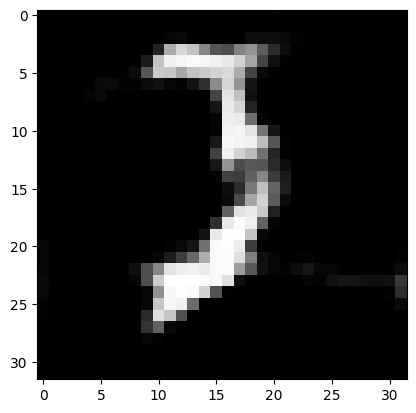

torch.Size([8192, 100]) tensor(0.0019) tensor(4.4838e-06)
torch.Size([8192]) tensor(0.0020) tensor(2.2737e-12)
torch.Size([128]) tensor(0.0088) tensor(5.9534e-06)
torch.Size([128]) tensor(0.0007) tensor(2.9287e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0040) tensor(1.5747e-05)
torch.Size([128]) tensor(1.0705e-09) tensor(4.2633e-12)
torch.Size([128]) tensor(0.0058) tensor(1.4593e-07)
torch.Size([128]) tensor(0.0039) tensor(-0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0048) tensor(0.0002)
torch.Size([64]) tensor(1.3427e-09) tensor(2.7612e-11)
torch.Size([64]) tensor(0.0179) tensor(-0.0012)
torch.Size([64]) tensor(0.0131) tensor(0.0133)
torch.Size([1, 64, 3, 3]) tensor(0.0865) tensor(-0.0217)
torch.Size([1]) tensor(nan) tensor(-0.1681)
[Epoch 2/200] [Batch 126/937/2001] [D loss: 0.490085] [G loss: 1.359828]
[Epoch 2/200] [Batch 127/937/2002] [D loss: 0.557896] [G loss: 0.855671]
[Epoch 2/200] [Batch 128/937/2003] [D loss: 0.576867] [G loss: 1.085044]
[Epoch 2/200] [Batch 129/937/2004] [D

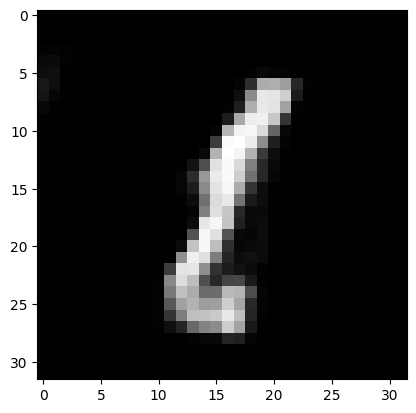

torch.Size([8192, 100]) tensor(0.0025) tensor(7.3485e-07)
torch.Size([8192]) tensor(0.0024) tensor(1.5461e-11)
torch.Size([128]) tensor(0.0120) tensor(-3.2414e-05)
torch.Size([128]) tensor(0.0007) tensor(-6.9000e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0053) tensor(-1.9892e-06)
torch.Size([128]) tensor(1.0833e-09) tensor(2.6333e-10)
torch.Size([128]) tensor(0.0050) tensor(1.4980e-05)
torch.Size([128]) tensor(0.0028) tensor(-0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0039) tensor(-0.0002)
torch.Size([64]) tensor(1.7184e-09) tensor(-2.7876e-10)
torch.Size([64]) tensor(0.0066) tensor(-0.0006)
torch.Size([64]) tensor(0.0054) tensor(-0.0008)
torch.Size([1, 64, 3, 3]) tensor(0.0380) tensor(0.0069)
torch.Size([1]) tensor(nan) tensor(0.0137)
[Epoch 2/200] [Batch 176/937/2051] [D loss: 0.585847] [G loss: 1.571595]
[Epoch 2/200] [Batch 177/937/2052] [D loss: 0.540544] [G loss: 1.106885]
[Epoch 2/200] [Batch 178/937/2053] [D loss: 0.576451] [G loss: 1.355562]
[Epoch 2/200] [Batch 179/937/2054

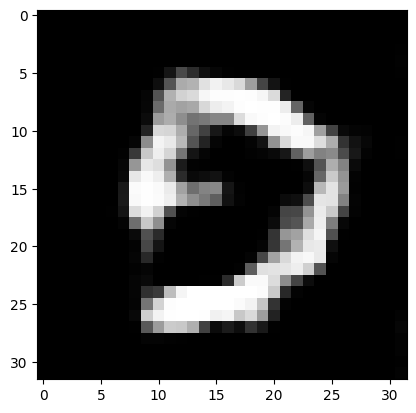

torch.Size([8192, 100]) tensor(0.0021) tensor(7.6261e-06)
torch.Size([8192]) tensor(0.0024) tensor(4.5475e-12)
torch.Size([128]) tensor(0.0094) tensor(-1.5249e-05)
torch.Size([128]) tensor(0.0005) tensor(1.1187e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0049) tensor(0.0001)
torch.Size([128]) tensor(9.8296e-10) tensor(-6.7644e-11)
torch.Size([128]) tensor(0.0061) tensor(4.1006e-05)
torch.Size([128]) tensor(0.0032) tensor(-1.7809e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0051) tensor(-0.0003)
torch.Size([64]) tensor(1.6096e-09) tensor(-4.3798e-11)
torch.Size([64]) tensor(0.0261) tensor(5.2957e-05)
torch.Size([64]) tensor(0.0103) tensor(0.0055)
torch.Size([1, 64, 3, 3]) tensor(0.1119) tensor(-0.0162)
torch.Size([1]) tensor(nan) tensor(-0.0897)
[Epoch 2/200] [Batch 226/937/2101] [D loss: 0.532742] [G loss: 1.090267]
[Epoch 2/200] [Batch 227/937/2102] [D loss: 0.540336] [G loss: 1.013175]
[Epoch 2/200] [Batch 228/937/2103] [D loss: 0.630536] [G loss: 1.233345]
[Epoch 2/200] [Batch 229/937/2

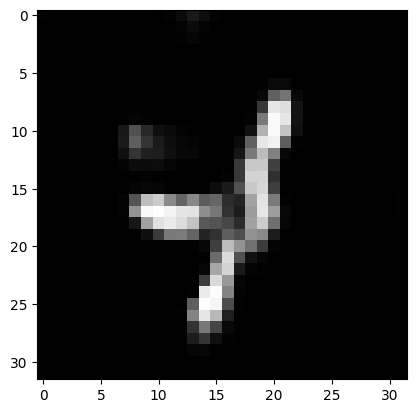

torch.Size([8192, 100]) tensor(0.0017) tensor(-6.5307e-06)
torch.Size([8192]) tensor(0.0022) tensor(-6.3665e-12)
torch.Size([128]) tensor(0.0088) tensor(1.4384e-06)
torch.Size([128]) tensor(0.0005) tensor(7.8923e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0040) tensor(-9.3482e-07)
torch.Size([128]) tensor(1.0212e-09) tensor(1.1719e-10)
torch.Size([128]) tensor(0.0046) tensor(-2.8230e-05)
torch.Size([128]) tensor(0.0023) tensor(0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0037) tensor(7.6759e-05)
torch.Size([64]) tensor(1.3399e-09) tensor(-1.2784e-10)
torch.Size([64]) tensor(0.0097) tensor(0.0003)
torch.Size([64]) tensor(0.0058) tensor(-0.0025)
torch.Size([1, 64, 3, 3]) tensor(0.0457) tensor(-0.0006)
torch.Size([1]) tensor(nan) tensor(0.0340)
[Epoch 2/200] [Batch 276/937/2151] [D loss: 0.540362] [G loss: 1.166248]
[Epoch 2/200] [Batch 277/937/2152] [D loss: 0.573045] [G loss: 1.085423]
[Epoch 2/200] [Batch 278/937/2153] [D loss: 0.549094] [G loss: 0.830256]
[Epoch 2/200] [Batch 279/937/2

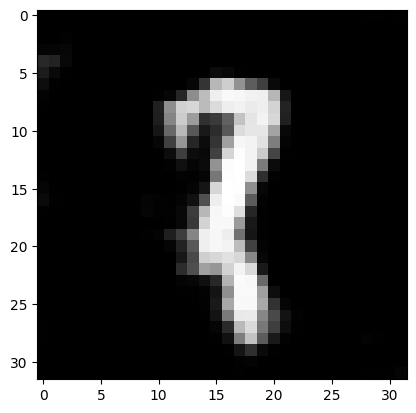

torch.Size([8192, 100]) tensor(0.0022) tensor(-1.9628e-06)
torch.Size([8192]) tensor(0.0035) tensor(-5.9117e-12)
torch.Size([128]) tensor(0.0099) tensor(3.3275e-05)
torch.Size([128]) tensor(0.0019) tensor(0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0049) tensor(-5.9420e-05)
torch.Size([128]) tensor(1.1791e-09) tensor(-1.5521e-10)
torch.Size([128]) tensor(0.0047) tensor(-4.7817e-06)
torch.Size([128]) tensor(0.0031) tensor(0.0005)
torch.Size([64, 128, 3, 3]) tensor(0.0041) tensor(-6.3137e-05)
torch.Size([64]) tensor(1.1106e-09) tensor(-6.8667e-10)
torch.Size([64]) tensor(0.0140) tensor(-0.0002)
torch.Size([64]) tensor(0.0093) tensor(-8.7732e-05)
torch.Size([1, 64, 3, 3]) tensor(0.0608) tensor(-0.0082)
torch.Size([1]) tensor(nan) tensor(-0.0087)
[Epoch 2/200] [Batch 326/937/2201] [D loss: 0.505340] [G loss: 1.169011]
[Epoch 2/200] [Batch 327/937/2202] [D loss: 0.607204] [G loss: 1.006233]
[Epoch 2/200] [Batch 328/937/2203] [D loss: 0.551991] [G loss: 1.366871]
[Epoch 2/200] [Batch 329/9

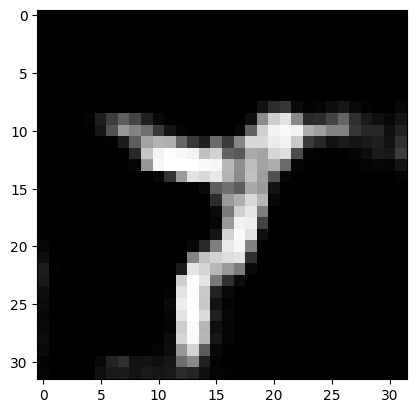

torch.Size([8192, 100]) tensor(0.0028) tensor(4.0118e-06)
torch.Size([8192]) tensor(0.0032) tensor(1.8190e-12)
torch.Size([128]) tensor(0.0118) tensor(6.0966e-05)
torch.Size([128]) tensor(0.0023) tensor(5.1687e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0062) tensor(-3.7758e-05)
torch.Size([128]) tensor(1.5556e-09) tensor(4.1837e-11)
torch.Size([128]) tensor(0.0078) tensor(3.3536e-05)
torch.Size([128]) tensor(0.0036) tensor(0.0006)
torch.Size([64, 128, 3, 3]) tensor(0.0056) tensor(0.0007)
torch.Size([64]) tensor(2.0200e-09) tensor(-5.3114e-10)
torch.Size([64]) tensor(0.0119) tensor(0.0003)
torch.Size([64]) tensor(0.0087) tensor(0.0019)
torch.Size([1, 64, 3, 3]) tensor(0.0619) tensor(-0.0184)
torch.Size([1]) tensor(nan) tensor(-0.0136)
[Epoch 2/200] [Batch 376/937/2251] [D loss: 0.594180] [G loss: 0.996282]
[Epoch 2/200] [Batch 377/937/2252] [D loss: 0.545942] [G loss: 1.140686]
[Epoch 2/200] [Batch 378/937/2253] [D loss: 0.540078] [G loss: 1.135947]
[Epoch 2/200] [Batch 379/937/2254] [D

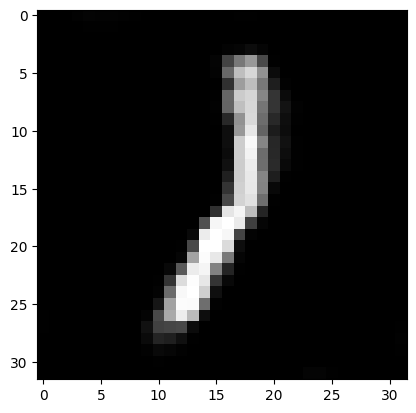

torch.Size([8192, 100]) tensor(0.0022) tensor(-5.1589e-06)
torch.Size([8192]) tensor(0.0028) tensor(-5.4570e-12)
torch.Size([128]) tensor(0.0113) tensor(1.1654e-05)
torch.Size([128]) tensor(0.0008) tensor(-0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0051) tensor(-4.5417e-05)
torch.Size([128]) tensor(1.2242e-09) tensor(2.3357e-10)
torch.Size([128]) tensor(0.0069) tensor(3.9336e-05)
torch.Size([128]) tensor(0.0041) tensor(-0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0046) tensor(-0.0001)
torch.Size([64]) tensor(1.4159e-09) tensor(-4.7748e-12)
torch.Size([64]) tensor(0.0178) tensor(-0.0010)
torch.Size([64]) tensor(0.0100) tensor(0.0057)
torch.Size([1, 64, 3, 3]) tensor(0.0827) tensor(-0.0001)
torch.Size([1]) tensor(nan) tensor(-0.0907)
[Epoch 2/200] [Batch 426/937/2301] [D loss: 0.431129] [G loss: 1.693799]
[Epoch 2/200] [Batch 427/937/2302] [D loss: 0.454030] [G loss: 1.437243]
[Epoch 2/200] [Batch 428/937/2303] [D loss: 0.511560] [G loss: 0.894608]
[Epoch 2/200] [Batch 429/937/2304] 

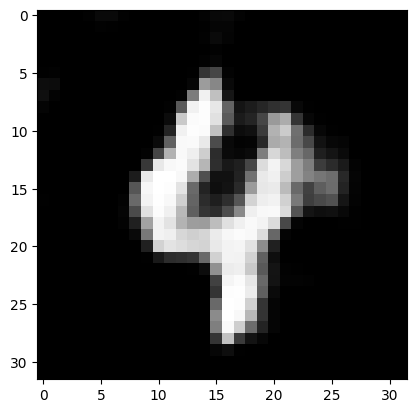

torch.Size([8192, 100]) tensor(0.0028) tensor(-2.7240e-06)
torch.Size([8192]) tensor(0.0024) tensor(9.0949e-13)
torch.Size([128]) tensor(0.0133) tensor(-0.0002)
torch.Size([128]) tensor(0.0027) tensor(-0.0003)
torch.Size([128, 128, 3, 3]) tensor(0.0057) tensor(-2.0380e-05)
torch.Size([128]) tensor(1.4455e-09) tensor(6.3736e-11)
torch.Size([128]) tensor(0.0063) tensor(2.3869e-05)
torch.Size([128]) tensor(0.0036) tensor(0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0063) tensor(-0.0007)
torch.Size([64]) tensor(1.7999e-09) tensor(4.1086e-10)
torch.Size([64]) tensor(0.0156) tensor(-0.0008)
torch.Size([64]) tensor(0.0153) tensor(-0.0121)
torch.Size([1, 64, 3, 3]) tensor(0.0745) tensor(0.0234)
torch.Size([1]) tensor(nan) tensor(0.0910)
[Epoch 2/200] [Batch 476/937/2351] [D loss: 0.703796] [G loss: 0.754588]
[Epoch 2/200] [Batch 477/937/2352] [D loss: 0.505645] [G loss: 0.779932]
[Epoch 2/200] [Batch 478/937/2353] [D loss: 0.475750] [G loss: 1.143652]
[Epoch 2/200] [Batch 479/937/2354] [D loss

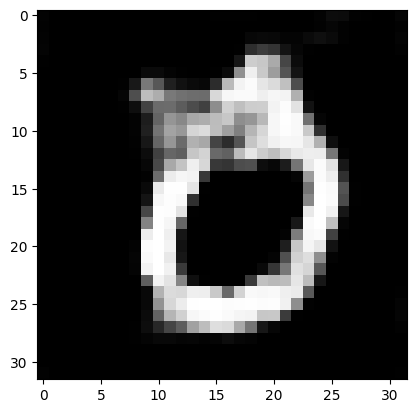

torch.Size([8192, 100]) tensor(0.0030) tensor(8.8172e-07)
torch.Size([8192]) tensor(0.0039) tensor(1.8190e-12)
torch.Size([128]) tensor(0.0136) tensor(-0.0001)
torch.Size([128]) tensor(0.0012) tensor(-1.6940e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0064) tensor(-6.0012e-05)
torch.Size([128]) tensor(1.4648e-09) tensor(3.0917e-10)
torch.Size([128]) tensor(0.0072) tensor(-4.4338e-05)
torch.Size([128]) tensor(0.0039) tensor(0.0007)
torch.Size([64, 128, 3, 3]) tensor(0.0057) tensor(-4.2435e-06)
torch.Size([64]) tensor(2.1515e-09) tensor(-3.3350e-10)
torch.Size([64]) tensor(0.0120) tensor(-0.0010)
torch.Size([64]) tensor(0.0124) tensor(-0.0095)
torch.Size([1, 64, 3, 3]) tensor(0.0604) tensor(0.0106)
torch.Size([1]) tensor(nan) tensor(0.0670)
[Epoch 2/200] [Batch 526/937/2401] [D loss: 0.539210] [G loss: 1.425605]
[Epoch 2/200] [Batch 527/937/2402] [D loss: 0.590441] [G loss: 1.424868]
[Epoch 2/200] [Batch 528/937/2403] [D loss: 0.595761] [G loss: 0.894519]
[Epoch 2/200] [Batch 529/937/2404

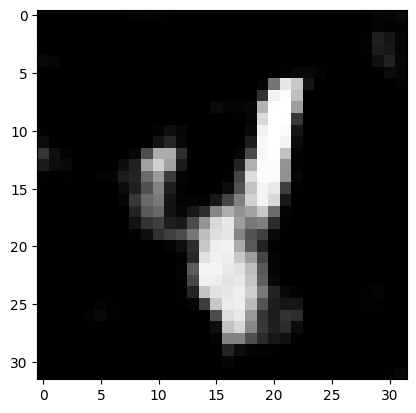

torch.Size([8192, 100]) tensor(0.0043) tensor(1.1370e-05)
torch.Size([8192]) tensor(0.0051) tensor(-1.4552e-11)
torch.Size([128]) tensor(0.0227) tensor(0.0001)
torch.Size([128]) tensor(0.0027) tensor(0.0004)
torch.Size([128, 128, 3, 3]) tensor(0.0089) tensor(-2.5471e-05)
torch.Size([128]) tensor(1.8949e-09) tensor(-4.1885e-10)
torch.Size([128]) tensor(0.0133) tensor(-3.3475e-05)
torch.Size([128]) tensor(0.0068) tensor(0.0005)
torch.Size([64, 128, 3, 3]) tensor(0.0074) tensor(0.0008)
torch.Size([64]) tensor(2.5001e-09) tensor(1.7315e-10)
torch.Size([64]) tensor(0.0218) tensor(-0.0009)
torch.Size([64]) tensor(0.0218) tensor(0.0191)
torch.Size([1, 64, 3, 3]) tensor(0.0999) tensor(-0.0280)
torch.Size([1]) tensor(nan) tensor(-0.1902)
[Epoch 2/200] [Batch 576/937/2451] [D loss: 0.436958] [G loss: 1.418012]
[Epoch 2/200] [Batch 577/937/2452] [D loss: 0.601018] [G loss: 0.837040]
[Epoch 2/200] [Batch 578/937/2453] [D loss: 0.542912] [G loss: 0.993644]
[Epoch 2/200] [Batch 579/937/2454] [D loss

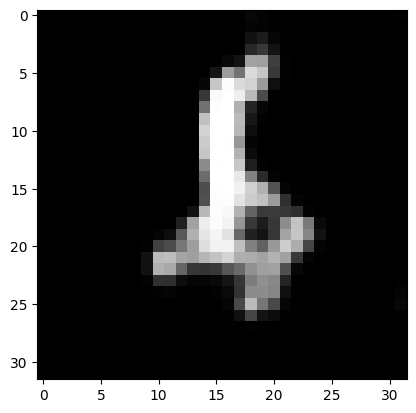

torch.Size([8192, 100]) tensor(0.0030) tensor(-3.2794e-06)
torch.Size([8192]) tensor(0.0034) tensor(-1.5007e-11)
torch.Size([128]) tensor(0.0132) tensor(4.5914e-06)
torch.Size([128]) tensor(0.0018) tensor(3.5338e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0067) tensor(3.4368e-05)
torch.Size([128]) tensor(1.6616e-09) tensor(6.9491e-11)
torch.Size([128]) tensor(0.0080) tensor(-3.5311e-05)
torch.Size([128]) tensor(0.0043) tensor(0.0012)
torch.Size([64, 128, 3, 3]) tensor(0.0064) tensor(0.0004)
torch.Size([64]) tensor(1.8335e-09) tensor(-3.0732e-10)
torch.Size([64]) tensor(0.0203) tensor(1.0155e-05)
torch.Size([64]) tensor(0.0129) tensor(-0.0044)
torch.Size([1, 64, 3, 3]) tensor(0.0951) tensor(0.0026)
torch.Size([1]) tensor(nan) tensor(0.0604)
[Epoch 2/200] [Batch 626/937/2501] [D loss: 0.478498] [G loss: 0.698985]
[Epoch 2/200] [Batch 627/937/2502] [D loss: 0.507251] [G loss: 1.086310]
[Epoch 2/200] [Batch 628/937/2503] [D loss: 0.528988] [G loss: 1.303093]
[Epoch 2/200] [Batch 629/937/250

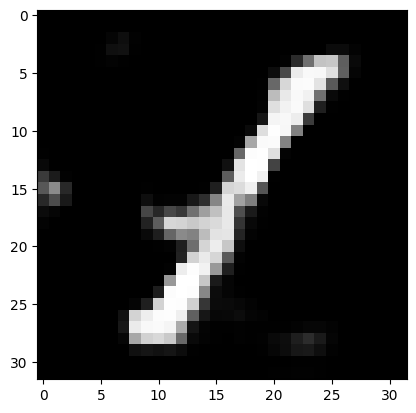

torch.Size([8192, 100]) tensor(0.0035) tensor(-5.4357e-06)
torch.Size([8192]) tensor(0.0036) tensor(9.5497e-12)
torch.Size([128]) tensor(0.0156) tensor(5.9086e-05)
torch.Size([128]) tensor(0.0016) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0076) tensor(-5.8506e-05)
torch.Size([128]) tensor(1.7424e-09) tensor(-7.0827e-11)
torch.Size([128]) tensor(0.0101) tensor(-2.7217e-05)
torch.Size([128]) tensor(0.0057) tensor(0.0013)
torch.Size([64, 128, 3, 3]) tensor(0.0080) tensor(-0.0009)
torch.Size([64]) tensor(2.8563e-09) tensor(-6.3756e-10)
torch.Size([64]) tensor(0.0265) tensor(-0.0018)
torch.Size([64]) tensor(0.0150) tensor(-0.0135)
torch.Size([1, 64, 3, 3]) tensor(0.1230) tensor(0.0303)
torch.Size([1]) tensor(nan) tensor(0.1323)
[Epoch 2/200] [Batch 676/937/2551] [D loss: 0.577968] [G loss: 1.264776]
[Epoch 2/200] [Batch 677/937/2552] [D loss: 0.414239] [G loss: 1.241979]
[Epoch 2/200] [Batch 678/937/2553] [D loss: 0.479274] [G loss: 0.768970]
[Epoch 2/200] [Batch 679/937/2554] [D

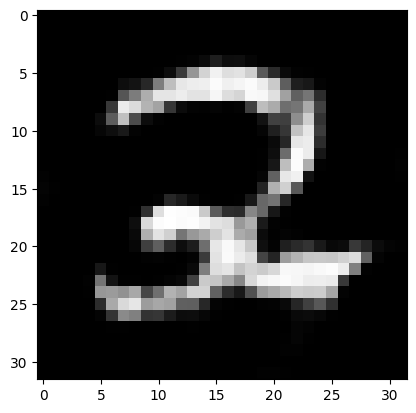

torch.Size([8192, 100]) tensor(0.0029) tensor(9.4184e-06)
torch.Size([8192]) tensor(0.0036) tensor(3.6380e-12)
torch.Size([128]) tensor(0.0146) tensor(6.4035e-05)
torch.Size([128]) tensor(0.0015) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0066) tensor(0.0001)
torch.Size([128]) tensor(1.5414e-09) tensor(1.5943e-10)
torch.Size([128]) tensor(0.0098) tensor(6.1351e-05)
torch.Size([128]) tensor(0.0059) tensor(-6.0570e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0079) tensor(-0.0002)
torch.Size([64]) tensor(1.8356e-09) tensor(3.4078e-10)
torch.Size([64]) tensor(0.0176) tensor(0.0002)
torch.Size([64]) tensor(0.0143) tensor(0.0123)
torch.Size([1, 64, 3, 3]) tensor(0.0857) tensor(-0.0173)
torch.Size([1]) tensor(nan) tensor(-0.1184)
[Epoch 2/200] [Batch 726/937/2601] [D loss: 0.538466] [G loss: 1.292117]
[Epoch 2/200] [Batch 727/937/2602] [D loss: 0.449266] [G loss: 1.107633]
[Epoch 2/200] [Batch 728/937/2603] [D loss: 0.537040] [G loss: 1.184284]
[Epoch 2/200] [Batch 729/937/2604] [D los

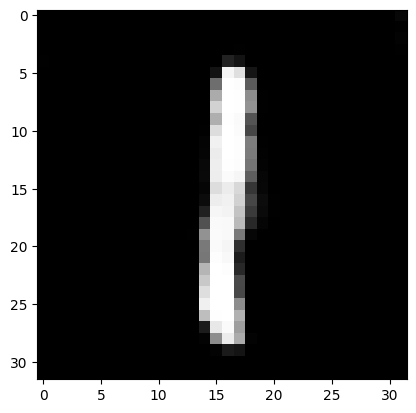

torch.Size([8192, 100]) tensor(0.0032) tensor(7.5633e-06)
torch.Size([8192]) tensor(0.0032) tensor(-2.1373e-11)
torch.Size([128]) tensor(0.0138) tensor(2.0886e-05)
torch.Size([128]) tensor(0.0013) tensor(-0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0070) tensor(0.0001)
torch.Size([128]) tensor(1.5180e-09) tensor(-2.0322e-11)
torch.Size([128]) tensor(0.0098) tensor(-1.9757e-06)
torch.Size([128]) tensor(0.0048) tensor(0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0075) tensor(-0.0005)
torch.Size([64]) tensor(2.6833e-09) tensor(-7.5408e-10)
torch.Size([64]) tensor(0.0160) tensor(-0.0013)
torch.Size([64]) tensor(0.0117) tensor(-0.0070)
torch.Size([1, 64, 3, 3]) tensor(0.0727) tensor(0.0048)
torch.Size([1]) tensor(nan) tensor(0.0703)
[Epoch 2/200] [Batch 776/937/2651] [D loss: 0.488580] [G loss: 1.199683]
[Epoch 2/200] [Batch 777/937/2652] [D loss: 0.576262] [G loss: 1.217875]
[Epoch 2/200] [Batch 778/937/2653] [D loss: 0.520821] [G loss: 1.100092]
[Epoch 2/200] [Batch 779/937/2654] [D los

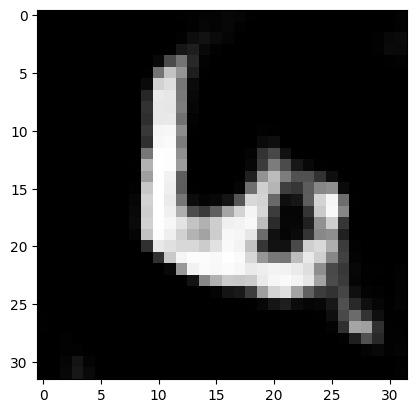

torch.Size([8192, 100]) tensor(0.0035) tensor(-1.3437e-06)
torch.Size([8192]) tensor(0.0043) tensor(-7.2760e-12)
torch.Size([128]) tensor(0.0171) tensor(-0.0001)
torch.Size([128]) tensor(0.0024) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0075) tensor(0.0001)
torch.Size([128]) tensor(1.5944e-09) tensor(7.9794e-11)
torch.Size([128]) tensor(0.0104) tensor(-2.6034e-05)
torch.Size([128]) tensor(0.0058) tensor(0.0007)
torch.Size([64, 128, 3, 3]) tensor(0.0083) tensor(-0.0003)
torch.Size([64]) tensor(2.6948e-09) tensor(-8.4822e-10)
torch.Size([64]) tensor(0.0282) tensor(0.0005)
torch.Size([64]) tensor(0.0162) tensor(-0.0122)
torch.Size([1, 64, 3, 3]) tensor(0.1353) tensor(0.0145)
torch.Size([1]) tensor(nan) tensor(0.1421)
[Epoch 2/200] [Batch 826/937/2701] [D loss: 0.570404] [G loss: 0.852792]
[Epoch 2/200] [Batch 827/937/2702] [D loss: 0.479767] [G loss: 0.970382]
[Epoch 2/200] [Batch 828/937/2703] [D loss: 0.448290] [G loss: 0.985540]
[Epoch 2/200] [Batch 829/937/2704] [D loss: 0.

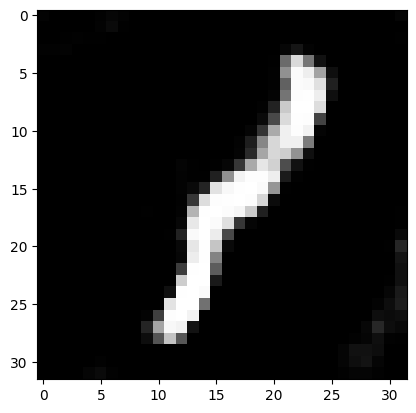

torch.Size([8192, 100]) tensor(0.0038) tensor(4.1257e-06)
torch.Size([8192]) tensor(0.0044) tensor(1.9554e-11)
torch.Size([128]) tensor(0.0184) tensor(0.0001)
torch.Size([128]) tensor(0.0015) tensor(9.7727e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0085) tensor(-0.0001)
torch.Size([128]) tensor(1.9279e-09) tensor(3.0582e-11)
torch.Size([128]) tensor(0.0103) tensor(8.7194e-05)
torch.Size([128]) tensor(0.0056) tensor(0.0008)
torch.Size([64, 128, 3, 3]) tensor(0.0092) tensor(-0.0004)
torch.Size([64]) tensor(2.6751e-09) tensor(-2.9490e-10)
torch.Size([64]) tensor(0.0232) tensor(-0.0017)
torch.Size([64]) tensor(0.0131) tensor(-0.0057)
torch.Size([1, 64, 3, 3]) tensor(0.1041) tensor(0.0003)
torch.Size([1]) tensor(nan) tensor(0.0489)
[Epoch 2/200] [Batch 876/937/2751] [D loss: 0.474319] [G loss: 1.599533]
[Epoch 2/200] [Batch 877/937/2752] [D loss: 0.434798] [G loss: 1.152349]
[Epoch 2/200] [Batch 878/937/2753] [D loss: 0.470987] [G loss: 1.110975]
[Epoch 2/200] [Batch 879/937/2754] [D loss: 

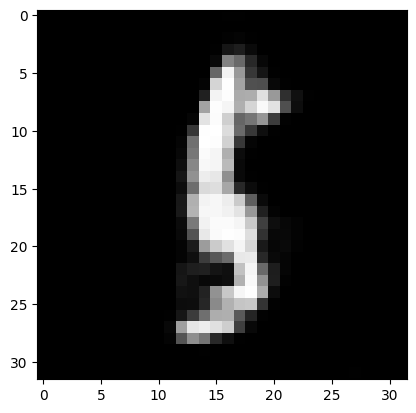

torch.Size([8192, 100]) tensor(0.0043) tensor(-1.0918e-05)
torch.Size([8192]) tensor(0.0049) tensor(4.6043e-12)
torch.Size([128]) tensor(0.0206) tensor(-0.0002)
torch.Size([128]) tensor(0.0012) tensor(0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0092) tensor(5.4346e-05)
torch.Size([128]) tensor(2.2017e-09) tensor(2.6387e-10)
torch.Size([128]) tensor(0.0143) tensor(6.8038e-05)
torch.Size([128]) tensor(0.0062) tensor(0.0010)
torch.Size([64, 128, 3, 3]) tensor(0.0107) tensor(0.0002)
torch.Size([64]) tensor(3.6787e-09) tensor(5.7662e-10)
torch.Size([64]) tensor(0.0270) tensor(-0.0007)
torch.Size([64]) tensor(0.0148) tensor(0.0021)
torch.Size([1, 64, 3, 3]) tensor(0.1279) tensor(-0.0009)
torch.Size([1]) tensor(nan) tensor(-0.0382)
[Epoch 2/200] [Batch 926/937/2801] [D loss: 0.431481] [G loss: 1.399446]
[Epoch 2/200] [Batch 927/937/2802] [D loss: 0.610726] [G loss: 0.827156]
[Epoch 2/200] [Batch 928/937/2803] [D loss: 0.621640] [G loss: 0.772851]
[Epoch 2/200] [Batch 929/937/2804] [D loss: 

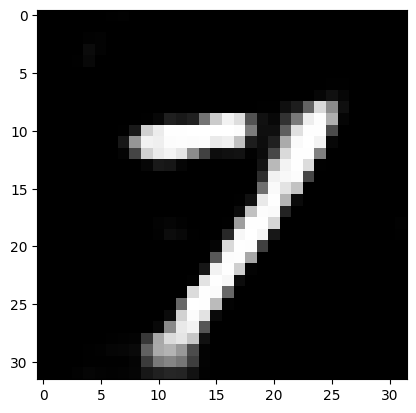

torch.Size([8192, 100]) tensor(0.0030) tensor(1.1657e-05)
torch.Size([8192]) tensor(0.0037) tensor(1.3188e-11)
torch.Size([128]) tensor(0.0131) tensor(3.2630e-05)
torch.Size([128]) tensor(0.0021) tensor(-6.9069e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0067) tensor(-6.7415e-05)
torch.Size([128]) tensor(1.6402e-09) tensor(1.1727e-10)
torch.Size([128]) tensor(0.0118) tensor(1.6880e-05)
torch.Size([128]) tensor(0.0059) tensor(0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0074) tensor(0.0003)
torch.Size([64]) tensor(2.4767e-09) tensor(1.3392e-10)
torch.Size([64]) tensor(0.0228) tensor(-0.0003)
torch.Size([64]) tensor(0.0137) tensor(0.0020)
torch.Size([1, 64, 3, 3]) tensor(0.1125) tensor(-0.0008)
torch.Size([1]) tensor(nan) tensor(-0.0209)
[Epoch 3/200] [Batch 39/937/2851] [D loss: 0.437575] [G loss: 0.952278]
[Epoch 3/200] [Batch 40/937/2852] [D loss: 0.493763] [G loss: 1.091319]
[Epoch 3/200] [Batch 41/937/2853] [D loss: 0.337243] [G loss: 1.489583]
[Epoch 3/200] [Batch 42/937/2854] [D lo

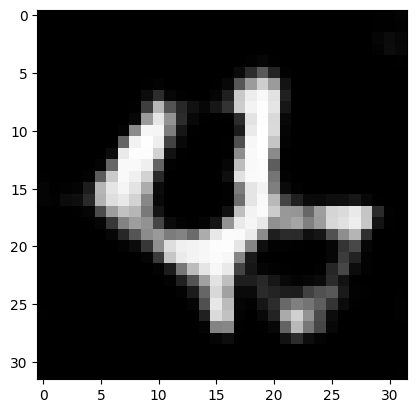

torch.Size([8192, 100]) tensor(0.0040) tensor(-1.2563e-06)
torch.Size([8192]) tensor(0.0043) tensor(2.0009e-11)
torch.Size([128]) tensor(0.0176) tensor(0.0002)
torch.Size([128]) tensor(0.0031) tensor(0.0005)
torch.Size([128, 128, 3, 3]) tensor(0.0084) tensor(0.0001)
torch.Size([128]) tensor(1.9119e-09) tensor(2.9704e-10)
torch.Size([128]) tensor(0.0108) tensor(-2.9065e-06)
torch.Size([128]) tensor(0.0066) tensor(-0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0084) tensor(0.0007)
torch.Size([64]) tensor(2.7561e-09) tensor(2.8172e-10)
torch.Size([64]) tensor(0.0199) tensor(-0.0013)
torch.Size([64]) tensor(0.0216) tensor(0.0179)
torch.Size([1, 64, 3, 3]) tensor(0.0932) tensor(-0.0266)
torch.Size([1]) tensor(nan) tensor(-0.1415)
[Epoch 3/200] [Batch 89/937/2901] [D loss: 0.525045] [G loss: 1.805134]
[Epoch 3/200] [Batch 90/937/2902] [D loss: 0.550106] [G loss: 0.884624]
[Epoch 3/200] [Batch 91/937/2903] [D loss: 0.541574] [G loss: 0.709859]
[Epoch 3/200] [Batch 92/937/2904] [D loss: 0.46185

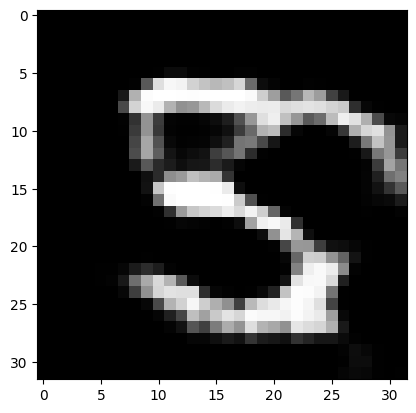

torch.Size([8192, 100]) tensor(0.0042) tensor(5.5708e-06)
torch.Size([8192]) tensor(0.0045) tensor(1.0004e-11)
torch.Size([128]) tensor(0.0210) tensor(1.4759e-05)
torch.Size([128]) tensor(0.0027) tensor(-0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0091) tensor(-4.5993e-05)
torch.Size([128]) tensor(2.0641e-09) tensor(5.6133e-12)
torch.Size([128]) tensor(0.0092) tensor(2.4327e-05)
torch.Size([128]) tensor(0.0055) tensor(0.0006)
torch.Size([64, 128, 3, 3]) tensor(0.0086) tensor(7.6996e-05)
torch.Size([64]) tensor(3.1070e-09) tensor(1.8497e-10)
torch.Size([64]) tensor(0.0338) tensor(-0.0019)
torch.Size([64]) tensor(0.0206) tensor(-0.0006)
torch.Size([1, 64, 3, 3]) tensor(0.1362) tensor(0.0033)
torch.Size([1]) tensor(nan) tensor(0.0164)
[Epoch 3/200] [Batch 139/937/2951] [D loss: 0.472958] [G loss: 1.165894]
[Epoch 3/200] [Batch 140/937/2952] [D loss: 0.482105] [G loss: 0.948746]
[Epoch 3/200] [Batch 141/937/2953] [D loss: 0.514940] [G loss: 1.272114]
[Epoch 3/200] [Batch 142/937/2954] [D

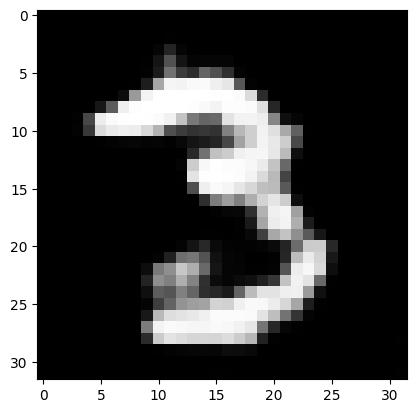

torch.Size([8192, 100]) tensor(0.0038) tensor(-2.6025e-06)
torch.Size([8192]) tensor(0.0043) tensor(5.4570e-12)
torch.Size([128]) tensor(0.0172) tensor(4.1212e-05)
torch.Size([128]) tensor(0.0015) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0081) tensor(-2.8733e-05)
torch.Size([128]) tensor(1.7836e-09) tensor(2.3127e-10)
torch.Size([128]) tensor(0.0094) tensor(-7.6271e-05)
torch.Size([128]) tensor(0.0060) tensor(0.0006)
torch.Size([64, 128, 3, 3]) tensor(0.0076) tensor(0.0005)
torch.Size([64]) tensor(3.2526e-09) tensor(-3.5999e-10)
torch.Size([64]) tensor(0.0141) tensor(-0.0002)
torch.Size([64]) tensor(0.0101) tensor(0.0050)
torch.Size([1, 64, 3, 3]) tensor(0.0703) tensor(-0.0016)
torch.Size([1]) tensor(nan) tensor(-0.0480)
[Epoch 3/200] [Batch 189/937/3001] [D loss: 0.483094] [G loss: 1.727167]
[Epoch 3/200] [Batch 190/937/3002] [D loss: 0.461602] [G loss: 2.001288]
[Epoch 3/200] [Batch 191/937/3003] [D loss: 0.430730] [G loss: 1.180817]
[Epoch 3/200] [Batch 192/937/3004] [D 

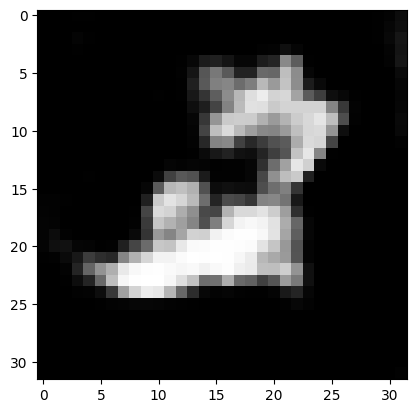

torch.Size([8192, 100]) tensor(0.0044) tensor(1.2740e-05)
torch.Size([8192]) tensor(0.0049) tensor(2.7285e-11)
torch.Size([128]) tensor(0.0194) tensor(9.4441e-06)
torch.Size([128]) tensor(0.0034) tensor(-0.0003)
torch.Size([128, 128, 3, 3]) tensor(0.0092) tensor(4.4478e-05)
torch.Size([128]) tensor(2.3716e-09) tensor(1.2312e-10)
torch.Size([128]) tensor(0.0160) tensor(7.8506e-05)
torch.Size([128]) tensor(0.0092) tensor(-5.5220e-06)
torch.Size([64, 128, 3, 3]) tensor(0.0096) tensor(0.0002)
torch.Size([64]) tensor(3.4901e-09) tensor(4.2814e-10)
torch.Size([64]) tensor(0.0185) tensor(-0.0023)
torch.Size([64]) tensor(0.0167) tensor(-0.0066)
torch.Size([1, 64, 3, 3]) tensor(0.0824) tensor(-0.0007)
torch.Size([1]) tensor(nan) tensor(0.0800)
[Epoch 3/200] [Batch 239/937/3051] [D loss: 0.452097] [G loss: 1.042345]
[Epoch 3/200] [Batch 240/937/3052] [D loss: 0.392557] [G loss: 1.436981]
[Epoch 3/200] [Batch 241/937/3053] [D loss: 0.539661] [G loss: 0.882134]
[Epoch 3/200] [Batch 242/937/3054] [

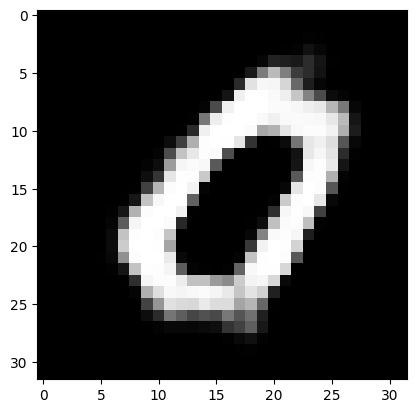

torch.Size([8192, 100]) tensor(0.0041) tensor(6.6275e-06)
torch.Size([8192]) tensor(0.0042) tensor(4.5475e-12)
torch.Size([128]) tensor(0.0193) tensor(6.4019e-05)
torch.Size([128]) tensor(0.0015) tensor(7.4390e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0093) tensor(0.0002)
torch.Size([128]) tensor(2.2072e-09) tensor(4.5355e-10)
torch.Size([128]) tensor(0.0132) tensor(6.6055e-05)
torch.Size([128]) tensor(0.0075) tensor(-0.0006)
torch.Size([64, 128, 3, 3]) tensor(0.0118) tensor(0.0001)
torch.Size([64]) tensor(3.2244e-09) tensor(-1.2415e-10)
torch.Size([64]) tensor(0.0229) tensor(0.0015)
torch.Size([64]) tensor(0.0199) tensor(0.0122)
torch.Size([1, 64, 3, 3]) tensor(0.1084) tensor(0.0092)
torch.Size([1]) tensor(nan) tensor(-0.1060)
[Epoch 3/200] [Batch 289/937/3101] [D loss: 0.467714] [G loss: 1.107051]
[Epoch 3/200] [Batch 290/937/3102] [D loss: 0.404270] [G loss: 1.589434]
[Epoch 3/200] [Batch 291/937/3103] [D loss: 0.498639] [G loss: 1.153374]
[Epoch 3/200] [Batch 292/937/3104] [D loss

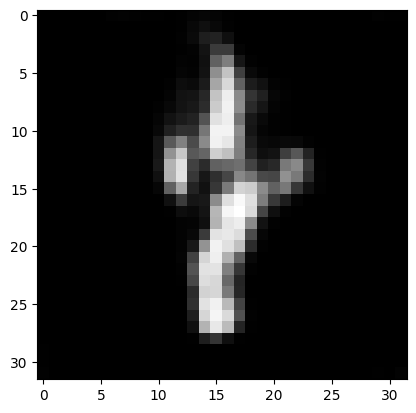

torch.Size([8192, 100]) tensor(0.0047) tensor(1.0414e-05)
torch.Size([8192]) tensor(0.0048) tensor(7.1623e-12)
torch.Size([128]) tensor(0.0243) tensor(2.5493e-05)
torch.Size([128]) tensor(0.0014) tensor(-8.7705e-06)
torch.Size([128, 128, 3, 3]) tensor(0.0099) tensor(-0.0002)
torch.Size([128]) tensor(2.3299e-09) tensor(5.5422e-13)
torch.Size([128]) tensor(0.0132) tensor(8.3579e-05)
torch.Size([128]) tensor(0.0072) tensor(0.0006)
torch.Size([64, 128, 3, 3]) tensor(0.0096) tensor(-0.0004)
torch.Size([64]) tensor(3.7001e-09) tensor(-4.7294e-11)
torch.Size([64]) tensor(0.0320) tensor(-0.0009)
torch.Size([64]) tensor(0.0161) tensor(-0.0100)
torch.Size([1, 64, 3, 3]) tensor(0.1305) tensor(0.0230)
torch.Size([1]) tensor(nan) tensor(0.1076)
[Epoch 3/200] [Batch 339/937/3151] [D loss: 0.472272] [G loss: 1.058561]
[Epoch 3/200] [Batch 340/937/3152] [D loss: 0.445051] [G loss: 1.523276]
[Epoch 3/200] [Batch 341/937/3153] [D loss: 0.478761] [G loss: 0.847015]
[Epoch 3/200] [Batch 342/937/3154] [D l

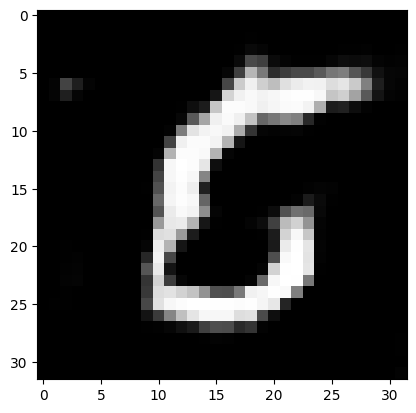

torch.Size([8192, 100]) tensor(0.0039) tensor(-6.4042e-07)
torch.Size([8192]) tensor(0.0040) tensor(-1.8190e-12)
torch.Size([128]) tensor(0.0193) tensor(-7.3622e-05)
torch.Size([128]) tensor(0.0013) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0082) tensor(0.0002)
torch.Size([128]) tensor(2.0336e-09) tensor(-6.7629e-11)
torch.Size([128]) tensor(0.0146) tensor(-2.1181e-05)
torch.Size([128]) tensor(0.0094) tensor(-0.0005)
torch.Size([64, 128, 3, 3]) tensor(0.0077) tensor(0.0002)
torch.Size([64]) tensor(3.2553e-09) tensor(-4.2689e-11)
torch.Size([64]) tensor(0.0172) tensor(-0.0004)
torch.Size([64]) tensor(0.0203) tensor(0.0189)
torch.Size([1, 64, 3, 3]) tensor(0.0744) tensor(-0.0095)
torch.Size([1]) tensor(nan) tensor(-0.1870)
[Epoch 3/200] [Batch 389/937/3201] [D loss: 0.470144] [G loss: 1.268744]
[Epoch 3/200] [Batch 390/937/3202] [D loss: 0.469873] [G loss: 1.028455]
[Epoch 3/200] [Batch 391/937/3203] [D loss: 0.416513] [G loss: 0.992621]
[Epoch 3/200] [Batch 392/937/3204] [D l

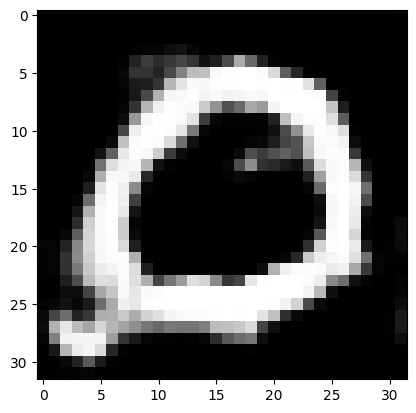

torch.Size([8192, 100]) tensor(0.0040) tensor(6.3016e-06)
torch.Size([8192]) tensor(0.0043) tensor(-7.2760e-12)
torch.Size([128]) tensor(0.0186) tensor(0.0001)
torch.Size([128]) tensor(0.0033) tensor(0.0007)
torch.Size([128, 128, 3, 3]) tensor(0.0088) tensor(0.0001)
torch.Size([128]) tensor(2.0174e-09) tensor(4.3127e-10)
torch.Size([128]) tensor(0.0165) tensor(-1.4404e-05)
torch.Size([128]) tensor(0.0079) tensor(0.0008)
torch.Size([64, 128, 3, 3]) tensor(0.0106) tensor(0.0009)
torch.Size([64]) tensor(2.8969e-09) tensor(1.1732e-10)
torch.Size([64]) tensor(0.0261) tensor(-0.0002)
torch.Size([64]) tensor(0.0221) tensor(-0.0053)
torch.Size([1, 64, 3, 3]) tensor(0.1148) tensor(0.0086)
torch.Size([1]) tensor(nan) tensor(0.0565)
[Epoch 3/200] [Batch 439/937/3251] [D loss: 0.507881] [G loss: 1.188665]
[Epoch 3/200] [Batch 440/937/3252] [D loss: 0.580601] [G loss: 1.524013]
[Epoch 3/200] [Batch 441/937/3253] [D loss: 0.464585] [G loss: 0.923349]
[Epoch 3/200] [Batch 442/937/3254] [D loss: 0.446

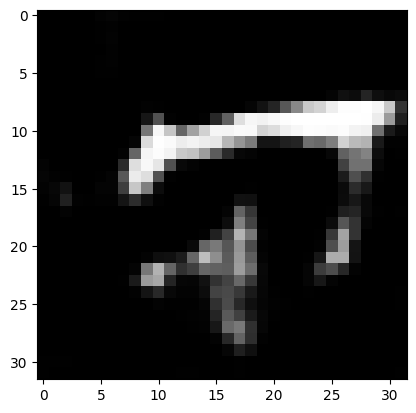

torch.Size([8192, 100]) tensor(0.0041) tensor(-1.3591e-05)
torch.Size([8192]) tensor(0.0046) tensor(9.0949e-12)
torch.Size([128]) tensor(0.0183) tensor(-3.9599e-05)
torch.Size([128]) tensor(0.0015) tensor(-0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0085) tensor(-9.6467e-05)
torch.Size([128]) tensor(1.7999e-09) tensor(3.1804e-11)
torch.Size([128]) tensor(0.0158) tensor(2.8253e-05)
torch.Size([128]) tensor(0.0102) tensor(0.0017)
torch.Size([64, 128, 3, 3]) tensor(0.0084) tensor(0.0003)
torch.Size([64]) tensor(3.0941e-09) tensor(-9.5019e-10)
torch.Size([64]) tensor(0.0184) tensor(-0.0010)
torch.Size([64]) tensor(0.0255) tensor(-0.0220)
torch.Size([1, 64, 3, 3]) tensor(0.0821) tensor(0.0186)
torch.Size([1]) tensor(nan) tensor(0.2030)
[Epoch 3/200] [Batch 489/937/3301] [D loss: 0.398406] [G loss: 1.359474]
[Epoch 3/200] [Batch 490/937/3302] [D loss: 0.512702] [G loss: 1.805313]
[Epoch 3/200] [Batch 491/937/3303] [D loss: 0.445672] [G loss: 1.179040]
[Epoch 3/200] [Batch 492/937/3304] [D 

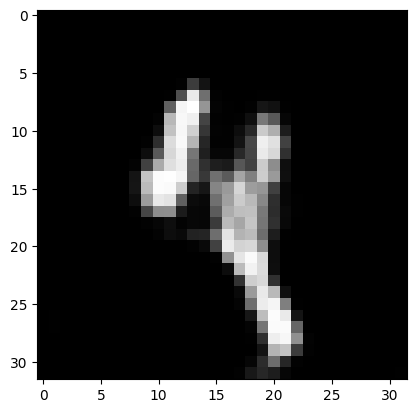

torch.Size([8192, 100]) tensor(0.0045) tensor(8.8773e-06)
torch.Size([8192]) tensor(0.0054) tensor(-3.1832e-12)
torch.Size([128]) tensor(0.0216) tensor(2.0891e-05)
torch.Size([128]) tensor(0.0026) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0098) tensor(-4.1564e-06)
torch.Size([128]) tensor(2.4705e-09) tensor(6.5356e-11)
torch.Size([128]) tensor(0.0153) tensor(4.9485e-05)
torch.Size([128]) tensor(0.0089) tensor(-5.4479e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0104) tensor(0.0005)
torch.Size([64]) tensor(4.4109e-09) tensor(-4.5020e-11)
torch.Size([64]) tensor(0.0248) tensor(-1.2467e-05)
torch.Size([64]) tensor(0.0170) tensor(0.0077)
torch.Size([1, 64, 3, 3]) tensor(0.1072) tensor(-0.0149)
torch.Size([1]) tensor(nan) tensor(-0.0648)
[Epoch 3/200] [Batch 539/937/3351] [D loss: 0.499044] [G loss: 1.056023]
[Epoch 3/200] [Batch 540/937/3352] [D loss: 0.511165] [G loss: 1.348190]
[Epoch 3/200] [Batch 541/937/3353] [D loss: 0.525534] [G loss: 0.778833]
[Epoch 3/200] [Batch 542/937/3

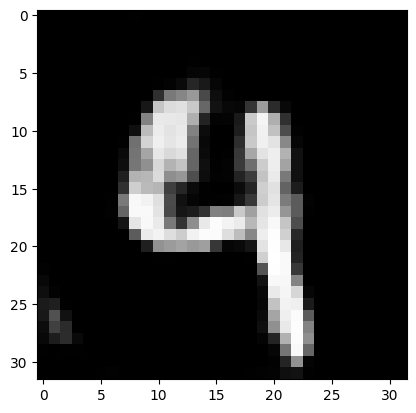

torch.Size([8192, 100]) tensor(0.0029) tensor(5.2993e-06)
torch.Size([8192]) tensor(0.0027) tensor(1.4552e-11)
torch.Size([128]) tensor(0.0144) tensor(-4.0971e-05)
torch.Size([128]) tensor(0.0014) tensor(-0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0067) tensor(-4.4512e-06)
torch.Size([128]) tensor(1.6957e-09) tensor(-1.0692e-10)
torch.Size([128]) tensor(0.0124) tensor(0.0001)
torch.Size([128]) tensor(0.0078) tensor(0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0070) tensor(-0.0006)
torch.Size([64]) tensor(2.9248e-09) tensor(-2.1146e-11)
torch.Size([64]) tensor(0.0269) tensor(-0.0021)
torch.Size([64]) tensor(0.0258) tensor(-0.0233)
torch.Size([1, 64, 3, 3]) tensor(0.1034) tensor(0.0314)
torch.Size([1]) tensor(nan) tensor(0.2283)
[Epoch 3/200] [Batch 589/937/3401] [D loss: 0.472583] [G loss: 1.080144]
[Epoch 3/200] [Batch 590/937/3402] [D loss: 0.422835] [G loss: 1.161855]
[Epoch 3/200] [Batch 591/937/3403] [D loss: 0.465469] [G loss: 1.575156]
[Epoch 3/200] [Batch 592/937/3404] [D los

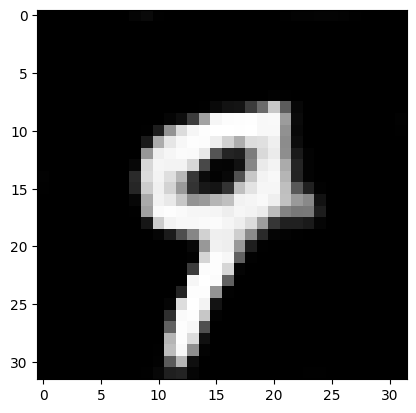

torch.Size([8192, 100]) tensor(0.0038) tensor(-1.0730e-06)
torch.Size([8192]) tensor(0.0044) tensor(1.8190e-12)
torch.Size([128]) tensor(0.0173) tensor(-6.9206e-05)
torch.Size([128]) tensor(0.0026) tensor(-0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0085) tensor(-6.9710e-06)
torch.Size([128]) tensor(2.1113e-09) tensor(3.5777e-10)
torch.Size([128]) tensor(0.0133) tensor(5.0824e-05)
torch.Size([128]) tensor(0.0074) tensor(0.0011)
torch.Size([64, 128, 3, 3]) tensor(0.0129) tensor(-0.0014)
torch.Size([64]) tensor(3.9661e-09) tensor(-5.3734e-10)
torch.Size([64]) tensor(0.0317) tensor(-0.0028)
torch.Size([64]) tensor(0.0260) tensor(-0.0163)
torch.Size([1, 64, 3, 3]) tensor(0.1472) tensor(0.0276)
torch.Size([1]) tensor(nan) tensor(0.1201)
[Epoch 3/200] [Batch 639/937/3451] [D loss: 0.500887] [G loss: 1.083886]
[Epoch 3/200] [Batch 640/937/3452] [D loss: 0.603902] [G loss: 1.196678]
[Epoch 3/200] [Batch 641/937/3453] [D loss: 0.413864] [G loss: 1.274164]
[Epoch 3/200] [Batch 642/937/3454] [D

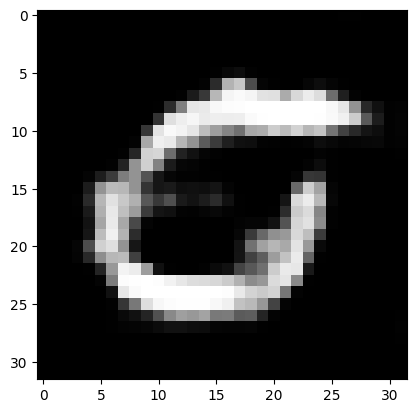

torch.Size([8192, 100]) tensor(0.0056) tensor(4.5614e-07)
torch.Size([8192]) tensor(0.0062) tensor(1.2278e-11)
torch.Size([128]) tensor(0.0241) tensor(0.0003)
torch.Size([128]) tensor(0.0031) tensor(0.0004)
torch.Size([128, 128, 3, 3]) tensor(0.0122) tensor(1.8473e-05)
torch.Size([128]) tensor(2.8232e-09) tensor(-3.7866e-10)
torch.Size([128]) tensor(0.0187) tensor(3.9903e-05)
torch.Size([128]) tensor(0.0115) tensor(0.0009)
torch.Size([64, 128, 3, 3]) tensor(0.0153) tensor(-0.0003)
torch.Size([64]) tensor(6.1890e-09) tensor(-1.3104e-09)
torch.Size([64]) tensor(0.0338) tensor(-0.0028)
torch.Size([64]) tensor(0.0230) tensor(1.1825e-05)
torch.Size([1, 64, 3, 3]) tensor(0.1481) tensor(0.0181)
torch.Size([1]) tensor(nan) tensor(-0.0218)
[Epoch 3/200] [Batch 689/937/3501] [D loss: 0.410442] [G loss: 1.142522]
[Epoch 3/200] [Batch 690/937/3502] [D loss: 0.434864] [G loss: 1.202797]
[Epoch 3/200] [Batch 691/937/3503] [D loss: 0.467464] [G loss: 1.700086]
[Epoch 3/200] [Batch 692/937/3504] [D lo

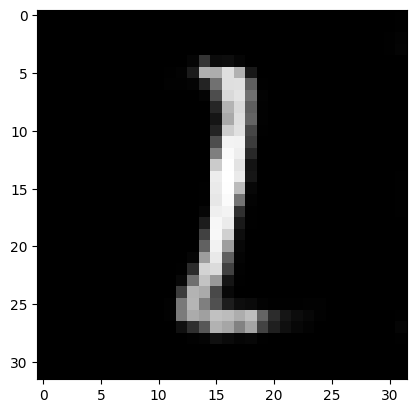

torch.Size([8192, 100]) tensor(0.0050) tensor(1.5911e-06)
torch.Size([8192]) tensor(0.0051) tensor(-4.0927e-12)
torch.Size([128]) tensor(0.0254) tensor(8.7745e-05)
torch.Size([128]) tensor(0.0031) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0099) tensor(-2.6143e-05)
torch.Size([128]) tensor(2.4816e-09) tensor(7.1473e-11)
torch.Size([128]) tensor(0.0175) tensor(3.5532e-05)
torch.Size([128]) tensor(0.0108) tensor(0.0008)
torch.Size([64, 128, 3, 3]) tensor(0.0140) tensor(-0.0008)
torch.Size([64]) tensor(3.4418e-09) tensor(-1.4059e-09)
torch.Size([64]) tensor(0.0498) tensor(-0.0022)
torch.Size([64]) tensor(0.0195) tensor(-0.0118)
torch.Size([1, 64, 3, 3]) tensor(0.2055) tensor(0.0205)
torch.Size([1]) tensor(nan) tensor(0.1274)
[Epoch 3/200] [Batch 739/937/3551] [D loss: 0.368911] [G loss: 1.496890]
[Epoch 3/200] [Batch 740/937/3552] [D loss: 0.608450] [G loss: 0.673871]
[Epoch 3/200] [Batch 741/937/3553] [D loss: 0.438754] [G loss: 1.004132]
[Epoch 3/200] [Batch 742/937/3554] [D l

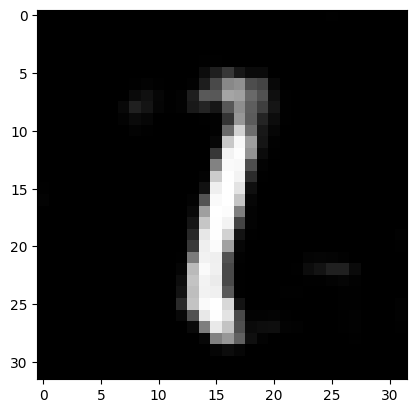

torch.Size([8192, 100]) tensor(0.0043) tensor(-4.0519e-06)
torch.Size([8192]) tensor(0.0049) tensor(-9.5497e-12)
torch.Size([128]) tensor(0.0204) tensor(-0.0002)
torch.Size([128]) tensor(0.0027) tensor(-0.0003)
torch.Size([128, 128, 3, 3]) tensor(0.0090) tensor(-8.6180e-05)
torch.Size([128]) tensor(2.1946e-09) tensor(-2.4764e-10)
torch.Size([128]) tensor(0.0122) tensor(8.0119e-05)
torch.Size([128]) tensor(0.0068) tensor(0.0009)
torch.Size([64, 128, 3, 3]) tensor(0.0094) tensor(0.0009)
torch.Size([64]) tensor(4.2279e-09) tensor(6.6132e-10)
torch.Size([64]) tensor(0.0193) tensor(-0.0016)
torch.Size([64]) tensor(0.0312) tensor(-0.0276)
torch.Size([1, 64, 3, 3]) tensor(0.0826) tensor(0.0312)
torch.Size([1]) tensor(nan) tensor(0.2361)
[Epoch 3/200] [Batch 789/937/3601] [D loss: 0.552236] [G loss: 0.865467]
[Epoch 3/200] [Batch 790/937/3602] [D loss: 0.485589] [G loss: 2.106713]
[Epoch 3/200] [Batch 791/937/3603] [D loss: 0.388219] [G loss: 1.690199]
[Epoch 3/200] [Batch 792/937/3604] [D los

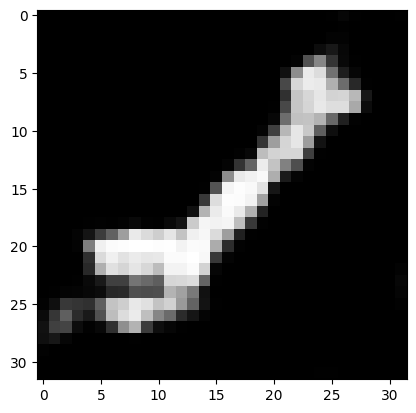

torch.Size([8192, 100]) tensor(0.0039) tensor(-4.7905e-06)
torch.Size([8192]) tensor(0.0042) tensor(-2.5238e-11)
torch.Size([128]) tensor(0.0212) tensor(-0.0001)
torch.Size([128]) tensor(0.0020) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0088) tensor(3.3930e-05)
torch.Size([128]) tensor(2.6596e-09) tensor(1.1471e-10)
torch.Size([128]) tensor(0.0123) tensor(-3.4177e-05)
torch.Size([128]) tensor(0.0063) tensor(0.0005)
torch.Size([64, 128, 3, 3]) tensor(0.0127) tensor(-0.0017)
torch.Size([64]) tensor(4.1557e-09) tensor(3.7790e-10)
torch.Size([64]) tensor(0.0500) tensor(-0.0020)
torch.Size([64]) tensor(0.0236) tensor(-0.0181)
torch.Size([1, 64, 3, 3]) tensor(0.2007) tensor(0.0458)
torch.Size([1]) tensor(nan) tensor(0.1937)
[Epoch 3/200] [Batch 839/937/3651] [D loss: 0.437837] [G loss: 1.135412]
[Epoch 3/200] [Batch 840/937/3652] [D loss: 0.393394] [G loss: 1.562438]
[Epoch 3/200] [Batch 841/937/3653] [D loss: 0.346491] [G loss: 1.361660]
[Epoch 3/200] [Batch 842/937/3654] [D loss

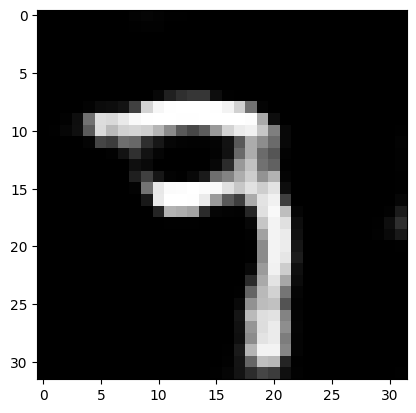

torch.Size([8192, 100]) tensor(0.0032) tensor(-2.5826e-06)
torch.Size([8192]) tensor(0.0035) tensor(3.6380e-12)
torch.Size([128]) tensor(0.0152) tensor(-5.0127e-05)
torch.Size([128]) tensor(0.0018) tensor(-8.7985e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0075) tensor(-2.0176e-05)
torch.Size([128]) tensor(1.6118e-09) tensor(1.4211e-12)
torch.Size([128]) tensor(0.0126) tensor(8.9610e-05)
torch.Size([128]) tensor(0.0063) tensor(0.0014)
torch.Size([64, 128, 3, 3]) tensor(0.0119) tensor(-0.0003)
torch.Size([64]) tensor(4.0810e-09) tensor(-6.1118e-10)
torch.Size([64]) tensor(0.0472) tensor(0.0002)
torch.Size([64]) tensor(0.0236) tensor(0.0045)
torch.Size([1, 64, 3, 3]) tensor(0.1839) tensor(0.0051)
torch.Size([1]) tensor(nan) tensor(-0.0990)
[Epoch 3/200] [Batch 889/937/3701] [D loss: 0.328605] [G loss: 1.486704]
[Epoch 3/200] [Batch 890/937/3702] [D loss: 0.516525] [G loss: 2.003731]
[Epoch 3/200] [Batch 891/937/3703] [D loss: 0.632284] [G loss: 1.170715]
[Epoch 3/200] [Batch 892/937/3704]

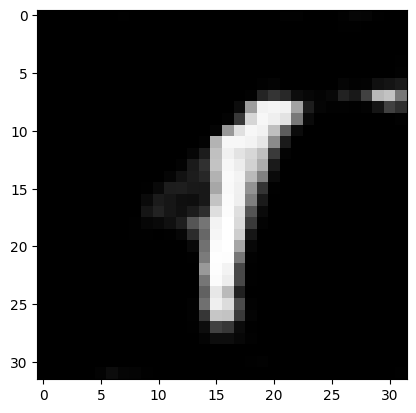

torch.Size([8192, 100]) tensor(0.0049) tensor(-1.0146e-05)
torch.Size([8192]) tensor(0.0054) tensor(-4.5475e-12)
torch.Size([128]) tensor(0.0211) tensor(0.0002)
torch.Size([128]) tensor(0.0025) tensor(5.4874e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0107) tensor(7.1881e-05)
torch.Size([128]) tensor(2.7777e-09) tensor(-1.2960e-11)
torch.Size([128]) tensor(0.0153) tensor(-6.0996e-05)
torch.Size([128]) tensor(0.0085) tensor(-0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0102) tensor(0.0003)
torch.Size([64]) tensor(4.5056e-09) tensor(-9.6725e-10)
torch.Size([64]) tensor(0.0226) tensor(-0.0007)
torch.Size([64]) tensor(0.0211) tensor(0.0158)
torch.Size([1, 64, 3, 3]) tensor(0.1006) tensor(-0.0079)
torch.Size([1]) tensor(nan) tensor(-0.0990)
[Epoch 4/200] [Batch 1/937/3751] [D loss: 0.301013] [G loss: 1.575531]
[Epoch 4/200] [Batch 2/937/3752] [D loss: 0.389913] [G loss: 0.829492]
[Epoch 4/200] [Batch 3/937/3753] [D loss: 0.411695] [G loss: 1.305094]
[Epoch 4/200] [Batch 4/937/3754] [D loss: 

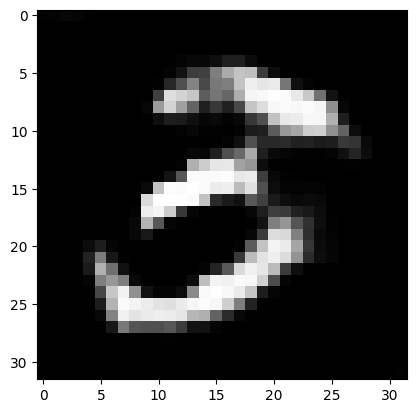

torch.Size([8192, 100]) tensor(0.0038) tensor(2.4792e-06)
torch.Size([8192]) tensor(0.0037) tensor(1.8190e-12)
torch.Size([128]) tensor(0.0168) tensor(-3.6659e-05)
torch.Size([128]) tensor(0.0020) tensor(-0.0003)
torch.Size([128, 128, 3, 3]) tensor(0.0093) tensor(0.0001)
torch.Size([128]) tensor(2.3446e-09) tensor(-1.7498e-10)
torch.Size([128]) tensor(0.0197) tensor(0.0003)
torch.Size([128]) tensor(0.0130) tensor(8.1973e-05)
torch.Size([64, 128, 3, 3]) tensor(0.0161) tensor(0.0005)
torch.Size([64]) tensor(5.2695e-09) tensor(-4.8183e-10)
torch.Size([64]) tensor(0.0620) tensor(-0.0002)
torch.Size([64]) tensor(0.0329) tensor(0.0227)
torch.Size([1, 64, 3, 3]) tensor(0.2464) tensor(-0.0690)
torch.Size([1]) tensor(nan) tensor(-0.2610)
[Epoch 4/200] [Batch 51/937/3801] [D loss: 0.476499] [G loss: 0.842437]
[Epoch 4/200] [Batch 52/937/3802] [D loss: 0.406398] [G loss: 1.406072]
[Epoch 4/200] [Batch 53/937/3803] [D loss: 0.368439] [G loss: 1.927860]
[Epoch 4/200] [Batch 54/937/3804] [D loss: 0.

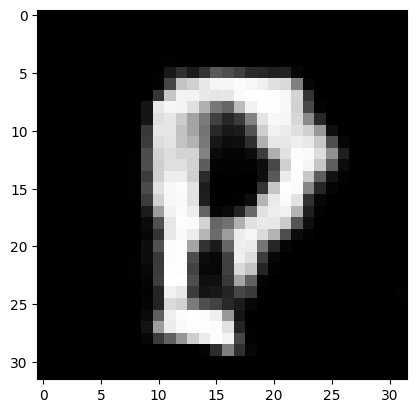

torch.Size([8192, 100]) tensor(0.0045) tensor(-4.8440e-06)
torch.Size([8192]) tensor(0.0044) tensor(8.8676e-12)
torch.Size([128]) tensor(0.0204) tensor(3.7058e-05)
torch.Size([128]) tensor(0.0017) tensor(0.0003)
torch.Size([128, 128, 3, 3]) tensor(0.0102) tensor(-5.3963e-05)
torch.Size([128]) tensor(2.6075e-09) tensor(2.3732e-11)
torch.Size([128]) tensor(0.0172) tensor(-3.2393e-05)
torch.Size([128]) tensor(0.0115) tensor(0.0011)
torch.Size([64, 128, 3, 3]) tensor(0.0104) tensor(0.0006)
torch.Size([64]) tensor(4.7540e-09) tensor(-4.5270e-10)
torch.Size([64]) tensor(0.0261) tensor(-0.0006)
torch.Size([64]) tensor(0.0145) tensor(-0.0031)
torch.Size([1, 64, 3, 3]) tensor(0.1327) tensor(-0.0007)
torch.Size([1]) tensor(nan) tensor(0.0261)
[Epoch 4/200] [Batch 101/937/3851] [D loss: 0.460308] [G loss: 1.232381]
[Epoch 4/200] [Batch 102/937/3852] [D loss: 0.349639] [G loss: 1.310376]
[Epoch 4/200] [Batch 103/937/3853] [D loss: 0.505572] [G loss: 1.181459]
[Epoch 4/200] [Batch 104/937/3854] [D 

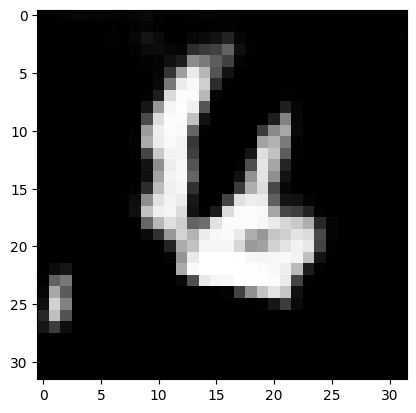

torch.Size([8192, 100]) tensor(0.0046) tensor(-2.0790e-06)
torch.Size([8192]) tensor(0.0051) tensor(8.1855e-12)
torch.Size([128]) tensor(0.0216) tensor(-0.0002)
torch.Size([128]) tensor(0.0023) tensor(-0.0004)
torch.Size([128, 128, 3, 3]) tensor(0.0102) tensor(3.7334e-05)
torch.Size([128]) tensor(2.4833e-09) tensor(-6.9065e-11)
torch.Size([128]) tensor(0.0140) tensor(-4.2478e-05)
torch.Size([128]) tensor(0.0090) tensor(0.0007)
torch.Size([64, 128, 3, 3]) tensor(0.0099) tensor(0.0002)
torch.Size([64]) tensor(5.2180e-09) tensor(8.8676e-12)
torch.Size([64]) tensor(0.0195) tensor(-0.0013)
torch.Size([64]) tensor(0.0270) tensor(-0.0199)
torch.Size([1, 64, 3, 3]) tensor(0.0859) tensor(0.0309)
torch.Size([1]) tensor(nan) tensor(0.1667)
[Epoch 4/200] [Batch 151/937/3901] [D loss: 0.368452] [G loss: 1.712340]
[Epoch 4/200] [Batch 152/937/3902] [D loss: 0.396692] [G loss: 2.212022]
[Epoch 4/200] [Batch 153/937/3903] [D loss: 0.457606] [G loss: 1.590712]
[Epoch 4/200] [Batch 154/937/3904] [D loss

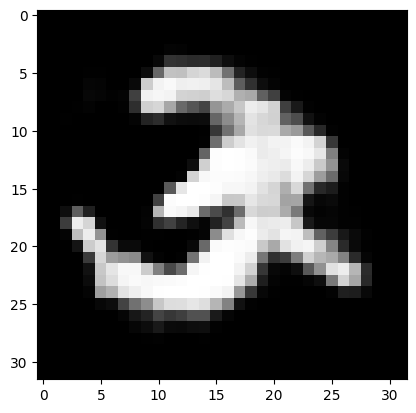

torch.Size([8192, 100]) tensor(0.0059) tensor(2.4630e-06)
torch.Size([8192]) tensor(0.0058) tensor(-1.3301e-11)
torch.Size([128]) tensor(0.0271) tensor(0.0002)
torch.Size([128]) tensor(0.0024) tensor(4.2683e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0134) tensor(0.0004)
torch.Size([128]) tensor(3.1885e-09) tensor(-4.4361e-10)
torch.Size([128]) tensor(0.0215) tensor(0.0002)
torch.Size([128]) tensor(0.0126) tensor(-0.0004)
torch.Size([64, 128, 3, 3]) tensor(0.0133) tensor(-0.0015)
torch.Size([64]) tensor(6.0634e-09) tensor(2.3283e-10)
torch.Size([64]) tensor(0.0368) tensor(-0.0022)
torch.Size([64]) tensor(0.0376) tensor(0.0310)
torch.Size([1, 64, 3, 3]) tensor(0.1469) tensor(-0.0165)
torch.Size([1]) tensor(nan) tensor(-0.3082)
[Epoch 4/200] [Batch 201/937/3951] [D loss: 0.417846] [G loss: 1.019690]
[Epoch 4/200] [Batch 202/937/3952] [D loss: 0.364470] [G loss: 1.280872]
[Epoch 4/200] [Batch 203/937/3953] [D loss: 0.405764] [G loss: 1.920115]
[Epoch 4/200] [Batch 204/937/3954] [D loss: 0.

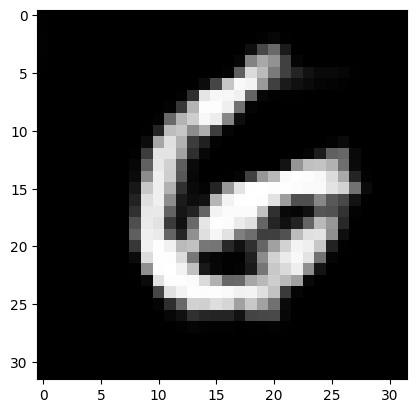

torch.Size([8192, 100]) tensor(0.0041) tensor(-2.7646e-06)
torch.Size([8192]) tensor(0.0047) tensor(-1.0914e-11)
torch.Size([128]) tensor(0.0180) tensor(0.0002)
torch.Size([128]) tensor(0.0027) tensor(4.6286e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0093) tensor(0.0002)
torch.Size([128]) tensor(2.5707e-09) tensor(-1.0579e-10)
torch.Size([128]) tensor(0.0158) tensor(0.0001)
torch.Size([128]) tensor(0.0089) tensor(0.0004)
torch.Size([64, 128, 3, 3]) tensor(0.0139) tensor(0.0007)
torch.Size([64]) tensor(4.6734e-09) tensor(-3.0792e-10)
torch.Size([64]) tensor(0.0447) tensor(0.0001)
torch.Size([64]) tensor(0.0446) tensor(0.0385)
torch.Size([1, 64, 3, 3]) tensor(0.1841) tensor(-0.0496)
torch.Size([1]) tensor(nan) tensor(-0.3835)
[Epoch 4/200] [Batch 251/937/4001] [D loss: 0.493302] [G loss: 0.715973]
[Epoch 4/200] [Batch 252/937/4002] [D loss: 0.275339] [G loss: 1.523258]
[Epoch 4/200] [Batch 253/937/4003] [D loss: 0.347962] [G loss: 2.336835]
[Epoch 4/200] [Batch 254/937/4004] [D loss: 0.4

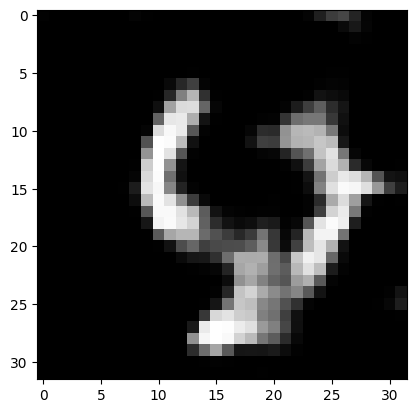

torch.Size([8192, 100]) tensor(0.0040) tensor(6.8780e-06)
torch.Size([8192]) tensor(0.0040) tensor(-8.6402e-12)
torch.Size([128]) tensor(0.0190) tensor(3.0348e-05)
torch.Size([128]) tensor(0.0020) tensor(-9.1186e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0091) tensor(-7.3950e-05)
torch.Size([128]) tensor(2.0911e-09) tensor(6.2556e-11)
torch.Size([128]) tensor(0.0129) tensor(-1.2407e-05)
torch.Size([128]) tensor(0.0078) tensor(-0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0099) tensor(-0.0002)
torch.Size([64]) tensor(4.3670e-09) tensor(-5.1500e-11)
torch.Size([64]) tensor(0.0263) tensor(-0.0003)
torch.Size([64]) tensor(0.0142) tensor(0.0049)
torch.Size([1, 64, 3, 3]) tensor(0.1052) tensor(-0.0013)
torch.Size([1]) tensor(nan) tensor(-0.0459)
[Epoch 4/200] [Batch 301/937/4051] [D loss: 0.433669] [G loss: 1.130344]
[Epoch 4/200] [Batch 302/937/4052] [D loss: 0.427051] [G loss: 1.352713]
[Epoch 4/200] [Batch 303/937/4053] [D loss: 0.495678] [G loss: 0.875248]
[Epoch 4/200] [Batch 304/937/40

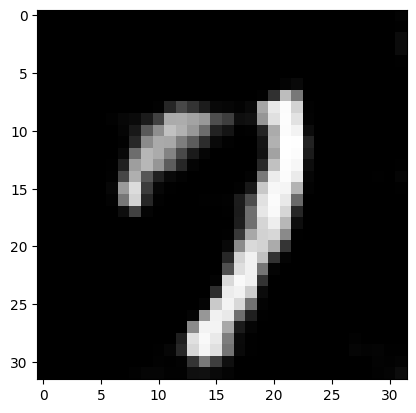

torch.Size([8192, 100]) tensor(0.0041) tensor(-9.3395e-06)
torch.Size([8192]) tensor(0.0043) tensor(-1.8190e-12)
torch.Size([128]) tensor(0.0185) tensor(0.0001)
torch.Size([128]) tensor(0.0024) tensor(0.0003)
torch.Size([128, 128, 3, 3]) tensor(0.0092) tensor(-1.9040e-05)
torch.Size([128]) tensor(2.2105e-09) tensor(1.1502e-10)
torch.Size([128]) tensor(0.0129) tensor(-4.0483e-05)
torch.Size([128]) tensor(0.0084) tensor(-0.0006)
torch.Size([64, 128, 3, 3]) tensor(0.0102) tensor(-0.0003)
torch.Size([64]) tensor(3.5824e-09) tensor(6.3665e-11)
torch.Size([64]) tensor(0.0187) tensor(0.0013)
torch.Size([64]) tensor(0.0286) tensor(0.0222)
torch.Size([1, 64, 3, 3]) tensor(0.0684) tensor(-0.0233)
torch.Size([1]) tensor(nan) tensor(-0.1696)
[Epoch 4/200] [Batch 351/937/4101] [D loss: 0.608936] [G loss: 1.769501]
[Epoch 4/200] [Batch 352/937/4102] [D loss: 0.599027] [G loss: 1.469641]
[Epoch 4/200] [Batch 353/937/4103] [D loss: 0.388438] [G loss: 0.871600]
[Epoch 4/200] [Batch 354/937/4104] [D los

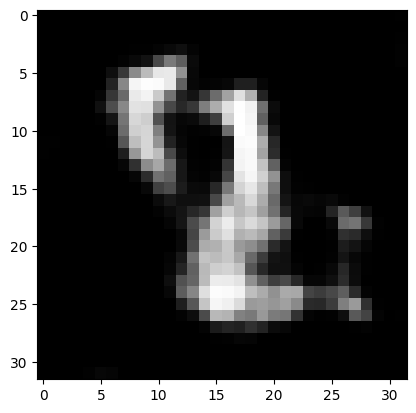

torch.Size([8192, 100]) tensor(0.0053) tensor(1.9087e-07)
torch.Size([8192]) tensor(0.0052) tensor(0.)
torch.Size([128]) tensor(0.0250) tensor(-1.6748e-05)
torch.Size([128]) tensor(0.0034) tensor(-0.0003)
torch.Size([128, 128, 3, 3]) tensor(0.0120) tensor(9.7729e-05)
torch.Size([128]) tensor(3.1081e-09) tensor(3.3131e-10)
torch.Size([128]) tensor(0.0225) tensor(8.8105e-05)
torch.Size([128]) tensor(0.0129) tensor(-0.0002)
torch.Size([64, 128, 3, 3]) tensor(0.0160) tensor(0.0005)
torch.Size([64]) tensor(5.6928e-09) tensor(-1.6945e-09)
torch.Size([64]) tensor(0.0425) tensor(-0.0019)
torch.Size([64]) tensor(0.0360) tensor(-0.0256)
torch.Size([1, 64, 3, 3]) tensor(0.1738) tensor(0.0096)
torch.Size([1]) tensor(nan) tensor(0.2556)
[Epoch 4/200] [Batch 401/937/4151] [D loss: 0.413576] [G loss: 0.731667]
[Epoch 4/200] [Batch 402/937/4152] [D loss: 0.290806] [G loss: 1.254100]
[Epoch 4/200] [Batch 403/937/4153] [D loss: 0.449905] [G loss: 1.755239]
[Epoch 4/200] [Batch 404/937/4154] [D loss: 0.5

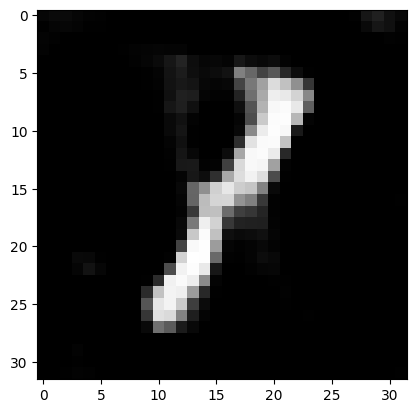

torch.Size([8192, 100]) tensor(0.0053) tensor(-6.5675e-07)
torch.Size([8192]) tensor(0.0061) tensor(1.0004e-11)
torch.Size([128]) tensor(0.0259) tensor(-3.0755e-05)
torch.Size([128]) tensor(0.0040) tensor(0.0004)
torch.Size([128, 128, 3, 3]) tensor(0.0116) tensor(-5.4019e-05)
torch.Size([128]) tensor(3.0439e-09) tensor(6.8283e-11)
torch.Size([128]) tensor(0.0176) tensor(0.0001)
torch.Size([128]) tensor(0.0102) tensor(0.0005)
torch.Size([64, 128, 3, 3]) tensor(0.0122) tensor(0.0002)
torch.Size([64]) tensor(5.1066e-09) tensor(-2.0225e-10)
torch.Size([64]) tensor(0.0382) tensor(-0.0027)
torch.Size([64]) tensor(0.0270) tensor(0.0049)
torch.Size([1, 64, 3, 3]) tensor(0.1385) tensor(0.0030)
torch.Size([1]) tensor(nan) tensor(-0.1079)
[Epoch 4/200] [Batch 451/937/4201] [D loss: 0.496629] [G loss: 1.819540]
[Epoch 4/200] [Batch 452/937/4202] [D loss: 0.503210] [G loss: 1.042570]
[Epoch 4/200] [Batch 453/937/4203] [D loss: 0.537110] [G loss: 1.735327]
[Epoch 4/200] [Batch 454/937/4204] [D loss:

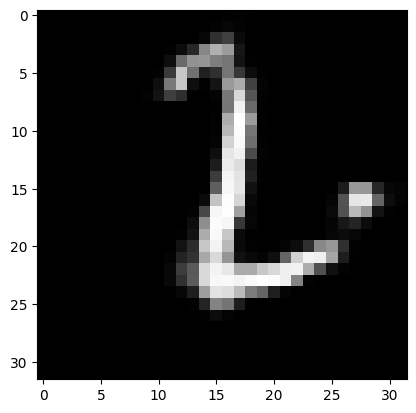

torch.Size([8192, 100]) tensor(0.0052) tensor(3.2675e-06)
torch.Size([8192]) tensor(0.0057) tensor(9.0949e-12)
torch.Size([128]) tensor(0.0235) tensor(0.0002)
torch.Size([128]) tensor(0.0032) tensor(0.0003)
torch.Size([128, 128, 3, 3]) tensor(0.0116) tensor(7.2572e-05)
torch.Size([128]) tensor(2.8480e-09) tensor(-8.3958e-11)
torch.Size([128]) tensor(0.0174) tensor(-8.6996e-06)
torch.Size([128]) tensor(0.0102) tensor(0.0017)
torch.Size([64, 128, 3, 3]) tensor(0.0124) tensor(0.0003)
torch.Size([64]) tensor(7.4376e-09) tensor(-5.4843e-10)
torch.Size([64]) tensor(0.0320) tensor(-0.0002)
torch.Size([64]) tensor(0.0215) tensor(-0.0039)
torch.Size([1, 64, 3, 3]) tensor(0.1153) tensor(0.0111)
torch.Size([1]) tensor(nan) tensor(0.0813)
[Epoch 4/200] [Batch 501/937/4251] [D loss: 0.439819] [G loss: 1.235963]
[Epoch 4/200] [Batch 502/937/4252] [D loss: 0.413196] [G loss: 1.201290]
[Epoch 4/200] [Batch 503/937/4253] [D loss: 0.377133] [G loss: 2.350052]
[Epoch 4/200] [Batch 504/937/4254] [D loss: 

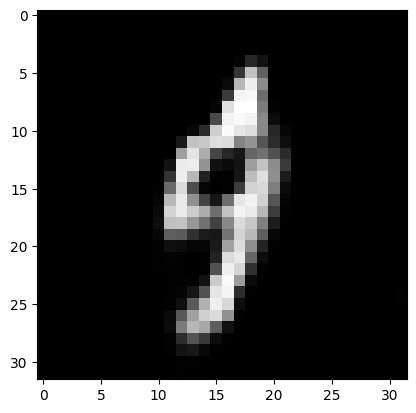

torch.Size([8192, 100]) tensor(0.0034) tensor(-1.9638e-06)
torch.Size([8192]) tensor(0.0032) tensor(9.0949e-12)
torch.Size([128]) tensor(0.0162) tensor(-0.0002)
torch.Size([128]) tensor(0.0022) tensor(-0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0076) tensor(-0.0001)
torch.Size([128]) tensor(1.9100e-09) tensor(3.8455e-11)
torch.Size([128]) tensor(0.0129) tensor(4.1670e-05)
torch.Size([128]) tensor(0.0076) tensor(-0.0011)
torch.Size([64, 128, 3, 3]) tensor(0.0101) tensor(-0.0018)
torch.Size([64]) tensor(4.0204e-09) tensor(-3.6027e-10)
torch.Size([64]) tensor(0.0285) tensor(-0.0018)
torch.Size([64]) tensor(0.0160) tensor(-0.0026)
torch.Size([1, 64, 3, 3]) tensor(0.1218) tensor(0.0131)
torch.Size([1]) tensor(nan) tensor(0.0289)
[Epoch 4/200] [Batch 551/937/4301] [D loss: 0.308391] [G loss: 2.194459]
[Epoch 4/200] [Batch 552/937/4302] [D loss: 0.320056] [G loss: 2.286650]
[Epoch 4/200] [Batch 553/937/4303] [D loss: 0.329350] [G loss: 1.301367]
[Epoch 4/200] [Batch 554/937/4304] [D loss: 

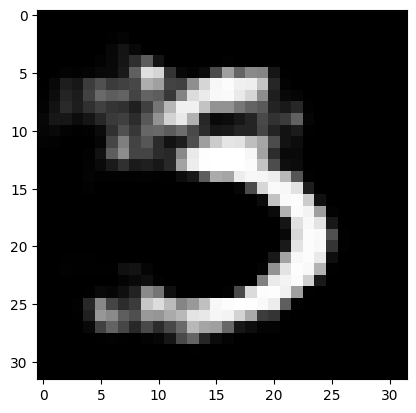

torch.Size([8192, 100]) tensor(0.0054) tensor(-7.1078e-07)
torch.Size([8192]) tensor(0.0055) tensor(-2.1828e-11)
torch.Size([128]) tensor(0.0269) tensor(-9.8976e-05)
torch.Size([128]) tensor(0.0027) tensor(0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0124) tensor(-0.0002)
torch.Size([128]) tensor(2.6823e-09) tensor(4.1666e-11)
torch.Size([128]) tensor(0.0198) tensor(0.0002)
torch.Size([128]) tensor(0.0114) tensor(0.0008)
torch.Size([64, 128, 3, 3]) tensor(0.0147) tensor(7.4165e-05)
torch.Size([64]) tensor(6.6115e-09) tensor(-6.6939e-10)
torch.Size([64]) tensor(0.0471) tensor(-0.0017)
torch.Size([64]) tensor(0.0321) tensor(-0.0067)
torch.Size([1, 64, 3, 3]) tensor(0.1808) tensor(0.0287)
torch.Size([1]) tensor(nan) tensor(0.0107)
[Epoch 4/200] [Batch 601/937/4351] [D loss: 0.377990] [G loss: 0.786275]
[Epoch 4/200] [Batch 602/937/4352] [D loss: 0.366242] [G loss: 1.214572]
[Epoch 4/200] [Batch 603/937/4353] [D loss: 0.506103] [G loss: 1.332326]
[Epoch 4/200] [Batch 604/937/4354] [D loss

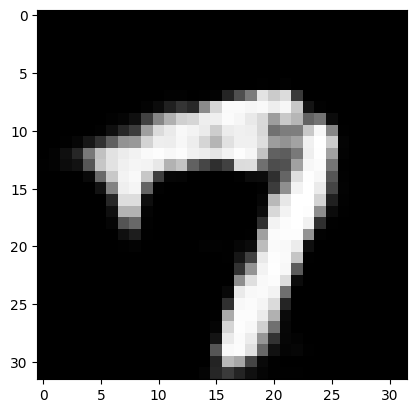

torch.Size([8192, 100]) tensor(0.0038) tensor(-3.3983e-06)
torch.Size([8192]) tensor(0.0043) tensor(-2.6944e-11)
torch.Size([128]) tensor(0.0181) tensor(6.6535e-05)
torch.Size([128]) tensor(0.0023) tensor(-6.1081e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0091) tensor(0.0002)
torch.Size([128]) tensor(2.2547e-09) tensor(2.5545e-10)
torch.Size([128]) tensor(0.0154) tensor(-3.2050e-05)
torch.Size([128]) tensor(0.0083) tensor(0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0133) tensor(0.0004)
torch.Size([64]) tensor(3.8248e-09) tensor(1.5348e-11)
torch.Size([64]) tensor(0.0399) tensor(-0.0001)
torch.Size([64]) tensor(0.0205) tensor(0.0132)
torch.Size([1, 64, 3, 3]) tensor(0.1568) tensor(-0.0203)
torch.Size([1]) tensor(nan) tensor(-0.1450)
[Epoch 4/200] [Batch 651/937/4401] [D loss: 0.340522] [G loss: 0.807078]
[Epoch 4/200] [Batch 652/937/4402] [D loss: 0.404348] [G loss: 1.024943]
[Epoch 4/200] [Batch 653/937/4403] [D loss: 0.311273] [G loss: 1.504627]
[Epoch 4/200] [Batch 654/937/4404] [D 

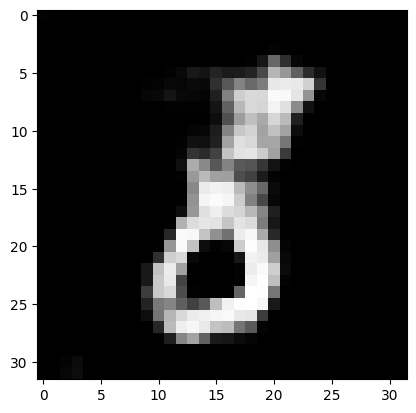

torch.Size([8192, 100]) tensor(0.0031) tensor(-6.5838e-06)
torch.Size([8192]) tensor(0.0035) tensor(-1.3642e-11)
torch.Size([128]) tensor(0.0126) tensor(-4.2292e-05)
torch.Size([128]) tensor(0.0018) tensor(-0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0072) tensor(-0.0001)
torch.Size([128]) tensor(1.6805e-09) tensor(2.0520e-11)
torch.Size([128]) tensor(0.0116) tensor(0.0001)
torch.Size([128]) tensor(0.0062) tensor(0.0014)
torch.Size([64, 128, 3, 3]) tensor(0.0095) tensor(0.0002)
torch.Size([64]) tensor(3.6937e-09) tensor(-6.5796e-12)
torch.Size([64]) tensor(0.0368) tensor(-0.0025)
torch.Size([64]) tensor(0.0177) tensor(0.0017)
torch.Size([1, 64, 3, 3]) tensor(0.1455) tensor(-0.0093)
torch.Size([1]) tensor(nan) tensor(-0.0733)
[Epoch 4/200] [Batch 701/937/4451] [D loss: 0.542419] [G loss: 0.928663]
[Epoch 4/200] [Batch 702/937/4452] [D loss: 0.550609] [G loss: 1.597530]
[Epoch 4/200] [Batch 703/937/4453] [D loss: 0.411068] [G loss: 2.107307]
[Epoch 4/200] [Batch 704/937/4454] [D loss: 

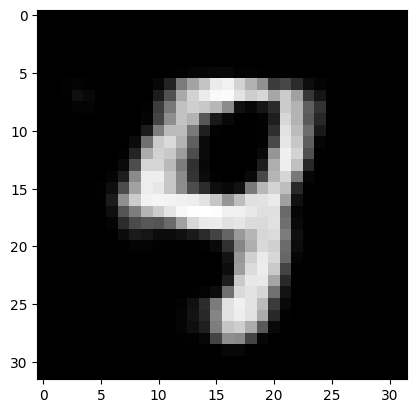

torch.Size([8192, 100]) tensor(0.0033) tensor(-1.6405e-06)
torch.Size([8192]) tensor(0.0033) tensor(0.)
torch.Size([128]) tensor(0.0168) tensor(-3.7611e-05)
torch.Size([128]) tensor(0.0016) tensor(-0.0002)
torch.Size([128, 128, 3, 3]) tensor(0.0081) tensor(-2.2457e-05)
torch.Size([128]) tensor(1.7601e-09) tensor(5.9146e-11)
torch.Size([128]) tensor(0.0163) tensor(2.1804e-05)
torch.Size([128]) tensor(0.0090) tensor(0.0001)
torch.Size([64, 128, 3, 3]) tensor(0.0128) tensor(0.0017)
torch.Size([64]) tensor(4.1488e-09) tensor(4.4815e-10)
torch.Size([64]) tensor(0.0643) tensor(-0.0010)
torch.Size([64]) tensor(0.0295) tensor(0.0239)
torch.Size([1, 64, 3, 3]) tensor(0.2427) tensor(-0.0298)
torch.Size([1]) tensor(nan) tensor(-0.2892)
[Epoch 4/200] [Batch 751/937/4501] [D loss: 0.663750] [G loss: 0.966810]
[Epoch 4/200] [Batch 752/937/4502] [D loss: 0.541282] [G loss: 1.679977]
[Epoch 4/200] [Batch 753/937/4503] [D loss: 0.278954] [G loss: 1.389212]
[Epoch 4/200] [Batch 754/937/4504] [D loss: 0.

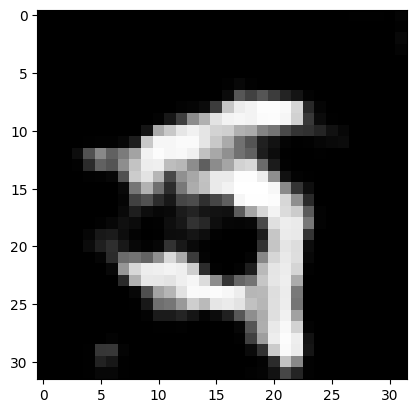

torch.Size([8192, 100]) tensor(0.0051) tensor(8.4984e-06)
torch.Size([8192]) tensor(0.0054) tensor(-1.2733e-11)
torch.Size([128]) tensor(0.0264) tensor(0.0006)
torch.Size([128]) tensor(0.0050) tensor(0.0007)
torch.Size([128, 128, 3, 3]) tensor(0.0117) tensor(0.0001)
torch.Size([128]) tensor(2.8538e-09) tensor(3.5159e-10)
torch.Size([128]) tensor(0.0195) tensor(-0.0001)
torch.Size([128]) tensor(0.0125) tensor(0.0014)
torch.Size([64, 128, 3, 3]) tensor(0.0124) tensor(0.0003)
torch.Size([64]) tensor(4.7914e-09) tensor(-5.5138e-11)
torch.Size([64]) tensor(0.0326) tensor(0.0007)
torch.Size([64]) tensor(0.0233) tensor(0.0149)
torch.Size([1, 64, 3, 3]) tensor(0.1117) tensor(-0.0283)
torch.Size([1]) tensor(nan) tensor(-0.1046)
[Epoch 4/200] [Batch 801/937/4551] [D loss: 0.464277] [G loss: 1.802827]
[Epoch 4/200] [Batch 802/937/4552] [D loss: 0.325954] [G loss: 1.882713]
[Epoch 4/200] [Batch 803/937/4553] [D loss: 0.444279] [G loss: 1.363882]
[Epoch 4/200] [Batch 804/937/4554] [D loss: 0.362349

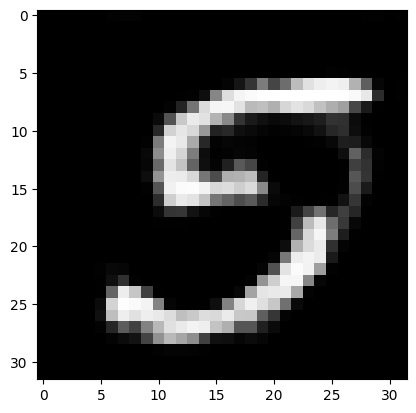

torch.Size([8192, 100]) tensor(0.0034) tensor(3.9168e-07)
torch.Size([8192]) tensor(0.0035) tensor(1.8190e-12)
torch.Size([128]) tensor(0.0165) tensor(0.0001)
torch.Size([128]) tensor(0.0019) tensor(0.0004)
torch.Size([128, 128, 3, 3]) tensor(0.0077) tensor(-4.7992e-05)
torch.Size([128]) tensor(1.7001e-09) tensor(-2.0373e-10)
torch.Size([128]) tensor(0.0112) tensor(-9.6489e-05)
torch.Size([128]) tensor(0.0066) tensor(0.0010)
torch.Size([64, 128, 3, 3]) tensor(0.0085) tensor(0.0005)
torch.Size([64]) tensor(3.8449e-09) tensor(2.6495e-10)
torch.Size([64]) tensor(0.0179) tensor(-0.0008)
torch.Size([64]) tensor(0.0156) tensor(0.0086)
torch.Size([1, 64, 3, 3]) tensor(0.0641) tensor(-0.0034)
torch.Size([1]) tensor(nan) tensor(-0.0890)
[Epoch 4/200] [Batch 851/937/4601] [D loss: 0.431322] [G loss: 0.673479]
[Epoch 4/200] [Batch 852/937/4602] [D loss: 0.489275] [G loss: 1.114602]
[Epoch 4/200] [Batch 853/937/4603] [D loss: 0.393371] [G loss: 1.569202]
[Epoch 4/200] [Batch 854/937/4604] [D loss:

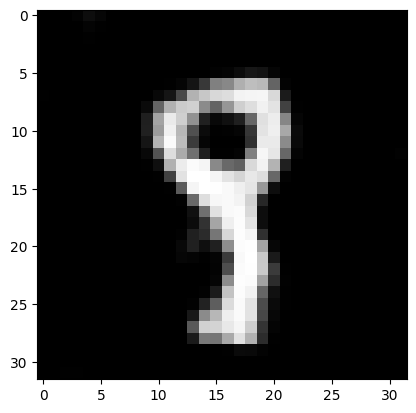

torch.Size([8192, 100]) tensor(0.0060) tensor(-6.6258e-06)
torch.Size([8192]) tensor(0.0066) tensor(-1.3188e-11)
torch.Size([128]) tensor(0.0272) tensor(-0.0003)
torch.Size([128]) tensor(0.0035) tensor(7.1301e-05)
torch.Size([128, 128, 3, 3]) tensor(0.0139) tensor(-0.0004)
torch.Size([128]) tensor(3.5435e-09) tensor(2.8894e-10)
torch.Size([128]) tensor(0.0228) tensor(0.0001)
torch.Size([128]) tensor(0.0124) tensor(0.0023)
torch.Size([64, 128, 3, 3]) tensor(0.0169) tensor(0.0003)
torch.Size([64]) tensor(7.1728e-09) tensor(3.2887e-10)
torch.Size([64]) tensor(0.0453) tensor(-0.0023)
torch.Size([64]) tensor(0.0377) tensor(-0.0233)
torch.Size([1, 64, 3, 3]) tensor(0.1733) tensor(0.0199)
torch.Size([1]) tensor(nan) tensor(0.2492)
[Epoch 4/200] [Batch 901/937/4651] [D loss: 0.376507] [G loss: 1.912730]
[Epoch 4/200] [Batch 902/937/4652] [D loss: 0.399334] [G loss: 0.920407]
[Epoch 4/200] [Batch 903/937/4653] [D loss: 0.456938] [G loss: 0.679961]
[Epoch 4/200] [Batch 904/937/4654] [D loss: 0.4

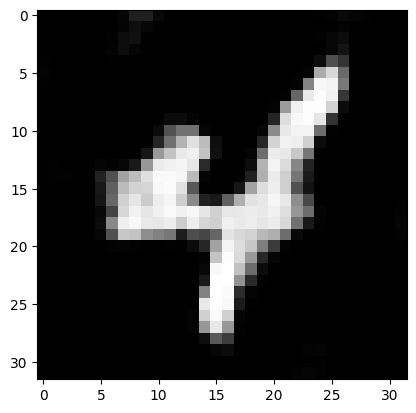

torch.Size([8192, 100]) tensor(0.0057) tensor(-7.0073e-06)
torch.Size([8192]) tensor(0.0061) tensor(-7.8444e-12)
torch.Size([128]) tensor(0.0279) tensor(0.0001)
torch.Size([128]) tensor(0.0029) tensor(0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0125) tensor(0.0001)
torch.Size([128]) tensor(2.7971e-09) tensor(1.6306e-10)
torch.Size([128]) tensor(0.0195) tensor(9.3106e-05)
torch.Size([128]) tensor(0.0117) tensor(0.0011)
torch.Size([64, 128, 3, 3]) tensor(0.0126) tensor(-0.0003)
torch.Size([64]) tensor(5.9686e-09) tensor(9.8021e-10)
torch.Size([64]) tensor(0.0250) tensor(-0.0015)
torch.Size([64]) tensor(0.0242) tensor(0.0126)
torch.Size([1, 64, 3, 3]) tensor(0.0832) tensor(-0.0146)
torch.Size([1]) tensor(nan) tensor(-0.1238)
[Epoch 5/200] [Batch 14/937/4701] [D loss: 0.307894] [G loss: 1.451809]
[Epoch 5/200] [Batch 15/937/4702] [D loss: 0.281473] [G loss: 2.506536]
[Epoch 5/200] [Batch 16/937/4703] [D loss: 0.444726] [G loss: 1.154679]
[Epoch 5/200] [Batch 17/937/4704] [D loss: 0.69776

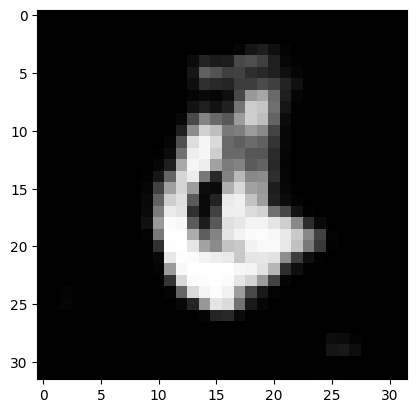

torch.Size([8192, 100]) tensor(0.0044) tensor(-6.1672e-06)
torch.Size([8192]) tensor(0.0043) tensor(-5.0022e-12)
torch.Size([128]) tensor(0.0214) tensor(8.9707e-05)
torch.Size([128]) tensor(0.0024) tensor(-0.0001)
torch.Size([128, 128, 3, 3]) tensor(0.0104) tensor(-3.2489e-05)
torch.Size([128]) tensor(2.7865e-09) tensor(-1.4472e-10)
torch.Size([128]) tensor(0.0226) tensor(0.0001)
torch.Size([128]) tensor(0.0132) tensor(0.0003)
torch.Size([64, 128, 3, 3]) tensor(0.0180) tensor(-0.0011)
torch.Size([64]) tensor(6.1509e-09) tensor(-9.6975e-11)
torch.Size([64]) tensor(0.0681) tensor(0.0019)
torch.Size([64]) tensor(0.0372) tensor(0.0357)
torch.Size([1, 64, 3, 3]) tensor(0.2595) tensor(-0.0238)
torch.Size([1]) tensor(nan) tensor(-0.3500)
[Epoch 5/200] [Batch 64/937/4751] [D loss: 0.365642] [G loss: 1.192802]
[Epoch 5/200] [Batch 65/937/4752] [D loss: 0.480738] [G loss: 1.740642]
[Epoch 5/200] [Batch 66/937/4753] [D loss: 0.394430] [G loss: 1.451917]
[Epoch 5/200] [Batch 67/937/4754] [D loss: 

KeyboardInterrupt: 

In [6]:
torch.manual_seed(1337)

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
# os.makedirs("../../data/mnist", exist_ok=True)
# dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST(
#         "../../data/mnist",
#         train=True,
#         download=True,
#         transform=transforms.Compose(
#             [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
#         ),
#     ),
#     batch_size=batch_size,
#     shuffle=False,
# )

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))


# ----------
#  Training
# ----------

for epoch in range(epochs):
    # for i, (imgs, _) in enumerate(dataloader):
    for i in range(features.shape[0] // batch_size):

        imgs = features[i * batch_size : (i + 1) * batch_size].unsqueeze(1)
        # Adversarial ground truths
        valid = torch.ones(imgs.shape[0], 1, requires_grad=False)
        noisy_fake = torch.randn([imgs.shape[0], 1], requires_grad=False) * 0.05 + 0.05
        noisy_valid = torch.randn([imgs.shape[0], 1], requires_grad=False) * 0.05 + 0.95

        # Configure input

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn([batch_size, latent_dim]) # Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(imgs), noisy_valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), noisy_fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        batches_done = epoch * features.shape[0] // batch_size + i

        print(
            "[Epoch %d/%d] [Batch %d/%d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, epochs, i, features.shape[0] // batch_size, batches_done, d_loss.item(), g_loss.item())
        )

        if batches_done % sample_interval == 0:
            img = gen_imgs.data[0].squeeze(0)
            print("std:", torch.std(img), "mean:", torch.mean(img), "min:", torch.min(img), "max:", torch.max(img))
            plt.imshow(img.cpu().numpy(), cmap='gray')
            plt.show()
            grad_stats(generator)
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)